# Bone Mineral Density Prediction

## Data Dictionary
This dataset was downloaded from Kaggle
https://www.kaggle.com/datasets/amarsharma768/bmd-data

| Column | Description |
|---|---|
| id |  id of individual |
| Age | Age of individual |
| Sex | Gender of individual |
| fracture | Fracture status of individual |
| weight_kg | Weight in kg of individual |
| height_cm |  Height in cm of individual |
| medication |  Medication individual is on |
| bmd  | Bone Mineral Density of individual |





## 1. Import Libraries and load Data

**What we do here:**
- Import essential libraries.
- Load `bmd.csv` .
- Show the first few rows to confirm the schema.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler , LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report ,roc_curve

RANDOM_STATE= 42

In [3]:
csv_path="../Data/raw/bmd.csv"

data=pd.read_csv(csv_path)
print("\nFirst 5 Rows of the dataset:")
data.head()



First 5 Rows of the dataset:


,id,age,sex,fracture,weight_kg,height_cm,medication,waiting_time,bmd
0,469,57.052768,F,no fracture,64.0,155.5,Anticonvulsant,18,0.8793
1,8724,75.741225,F,no fracture,78.0,162.0,No medication,56,0.7946
2,6736,70.778900,M,no fracture,73.0,170.5,No medication,10,0.9067
3,24180,78.247175,F,no fracture,60.0,148.0,No medication,14,0.7112
4,17072,54.191877,M,no fracture,55.0,161.0,No medication,20,0.7909


## 2. Understanding and exploring Data

**what we do here:**
- Inspect data types, missing values
- Get statistics


In [4]:
print("\nStatistical Summary:")
print(data.describe())
print("Non-numerical count")
print(data['fracture'].value_counts())
print(data['medication'].value_counts())
print(data["sex"].value_counts())



Statistical Summary:
                 id         age   weight_kg   height_cm  waiting_time  \
count    169.000000  169.000000  169.000000  169.000000    169.000000   
mean    9102.556213   63.631531   64.665680  160.254438     19.739645   
std     8744.623598   12.356936   11.537171    7.928272     15.800570   
min       35.000000   35.814058   36.000000  142.000000      5.000000   
25%     2018.000000   54.424211   56.000000  154.000000      9.000000   
50%     6702.000000   63.487837   64.500000  160.500000     14.000000   
75%    17100.000000   72.080558   73.000000  166.000000     24.000000   
max    24208.000000   88.753795   96.000000  177.000000     96.000000   

              bmd  
count  169.000000  
mean     0.783104  
std      0.166529  
min      0.407600  
25%      0.670800  
50%      0.786100  
75%      0.888800  
max      1.362400  
Non-numerical count
fracture
no fracture    119
fracture        50
Name: count, dtype: int64
medication
No medication      136
Glucocorticoi

In [5]:
print("\nData Types and Missing Values:")
data.isnull().sum()


Data Types and Missing Values:


id              0
age             0
sex             0
fracture        0
weight_kg       0
height_cm       0
medication      0
waiting_time    0
bmd             0
dtype: int64

## 3. Data Handling

**what we do here:**
- Drop irrelevant columns e.g. waiting_time

In [6]:
data.drop(columns=["waiting_time"], inplace=True)
print(data.columns)

Index(['id', 'age', 'sex', 'fracture', 'weight_kg', 'height_cm', 'medication',
       'bmd'],
      dtype='object')


## 4. Checking for imbalance ##
**what we do here** 
- counting variables in the column
- handling the imbalancy using simple duplication 

C:\Users\HP\AppData\Local\Temp\ipykernel_53288\3100918795.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


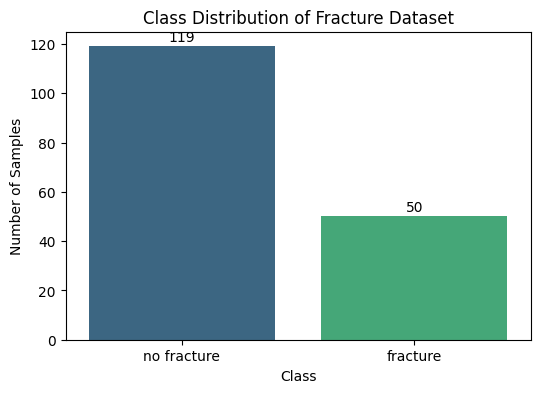

In [7]:
class_counts = data['fracture'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')

# Annotate bars with counts
for i, count in enumerate(class_counts.values):
    plt.text(i, count + 1, str(count), ha='center', va='bottom')

plt.title("Class Distribution of Fracture Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

In [8]:
from imblearn.over_sampling import RandomOverSampler

X = data.drop(columns=['fracture'])
y = data['fracture']

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)

print(y_res.value_counts())

fracture
no fracture    119
fracture       119
Name: count, dtype: int64


## 5. Outlier Detection and Handling

**what we do here:**
- Visualize the dataset to see the outliers
- Use IQR to handle outliers

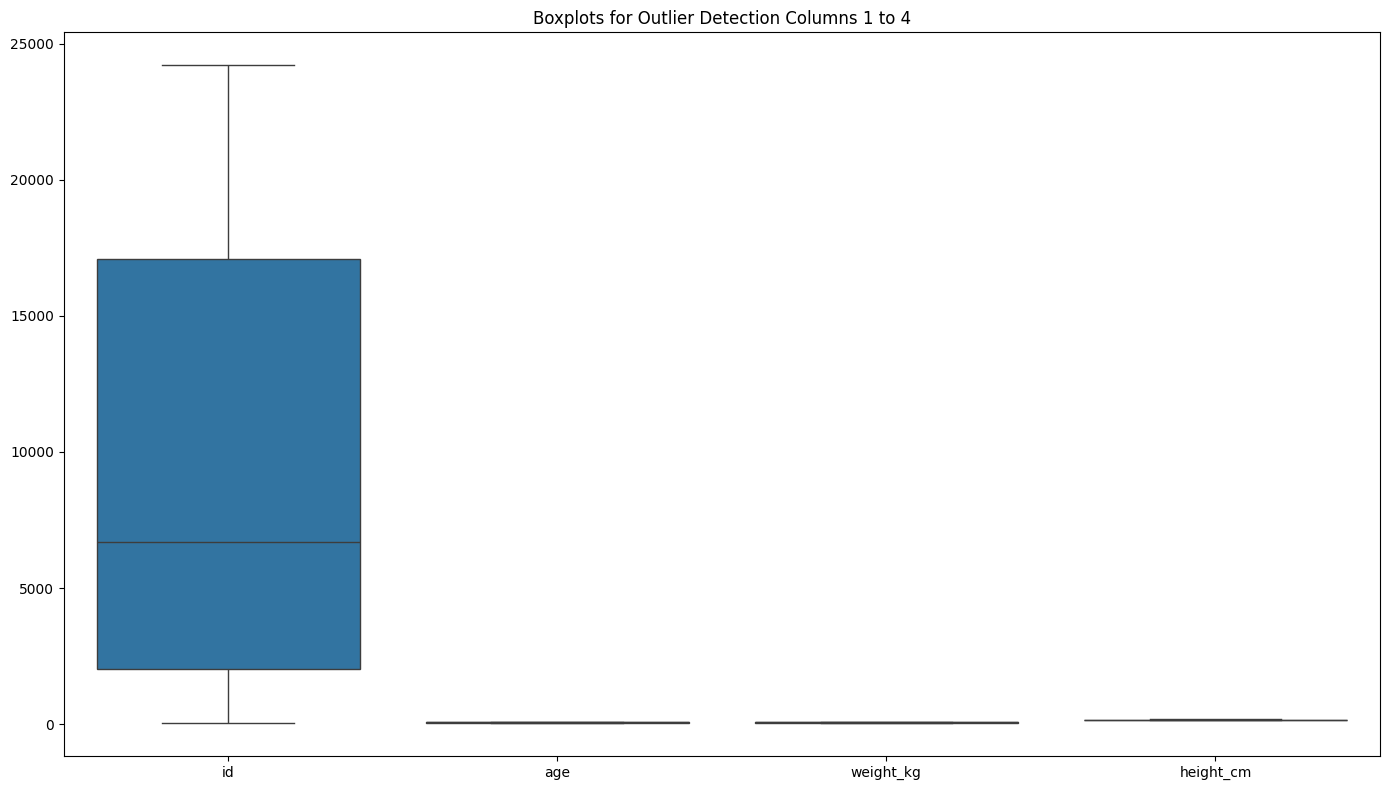

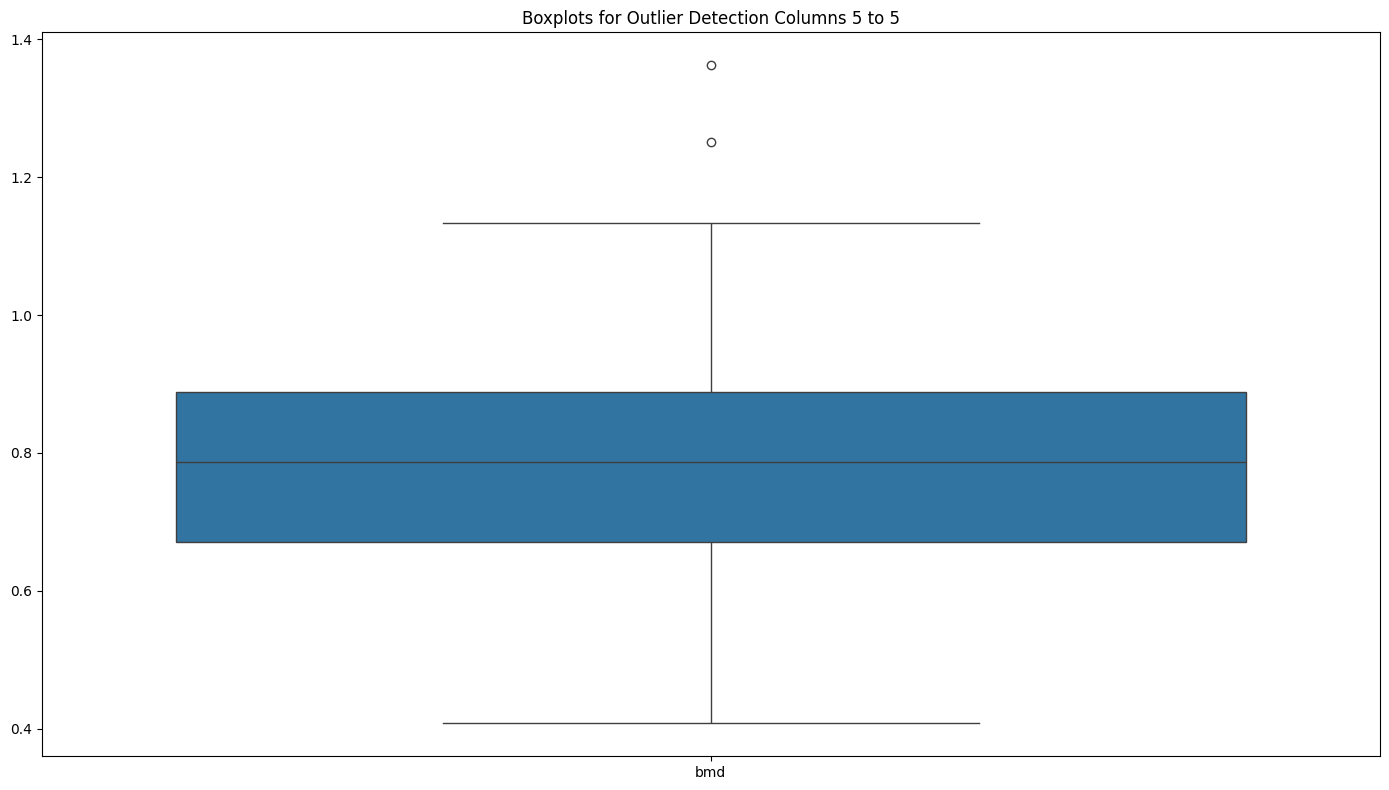

In [9]:
# Select only numeric columns
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
n_columns = len(numeric_cols)

group_size = 4
n_plots = (n_columns + group_size - 1) // group_size

for i in range(n_plots):
    start_col = i * group_size
    end_col = min((i + 1) * group_size, n_columns)
    cols_to_plot = numeric_cols[start_col:end_col]

    plt.figure(figsize=(14, 8))
    sns.boxplot(data=data[cols_to_plot])
    plt.title(f'Boxplots for Outlier Detection Columns {start_col + 1} to {end_col}')
    plt.tight_layout()
    plt.show()


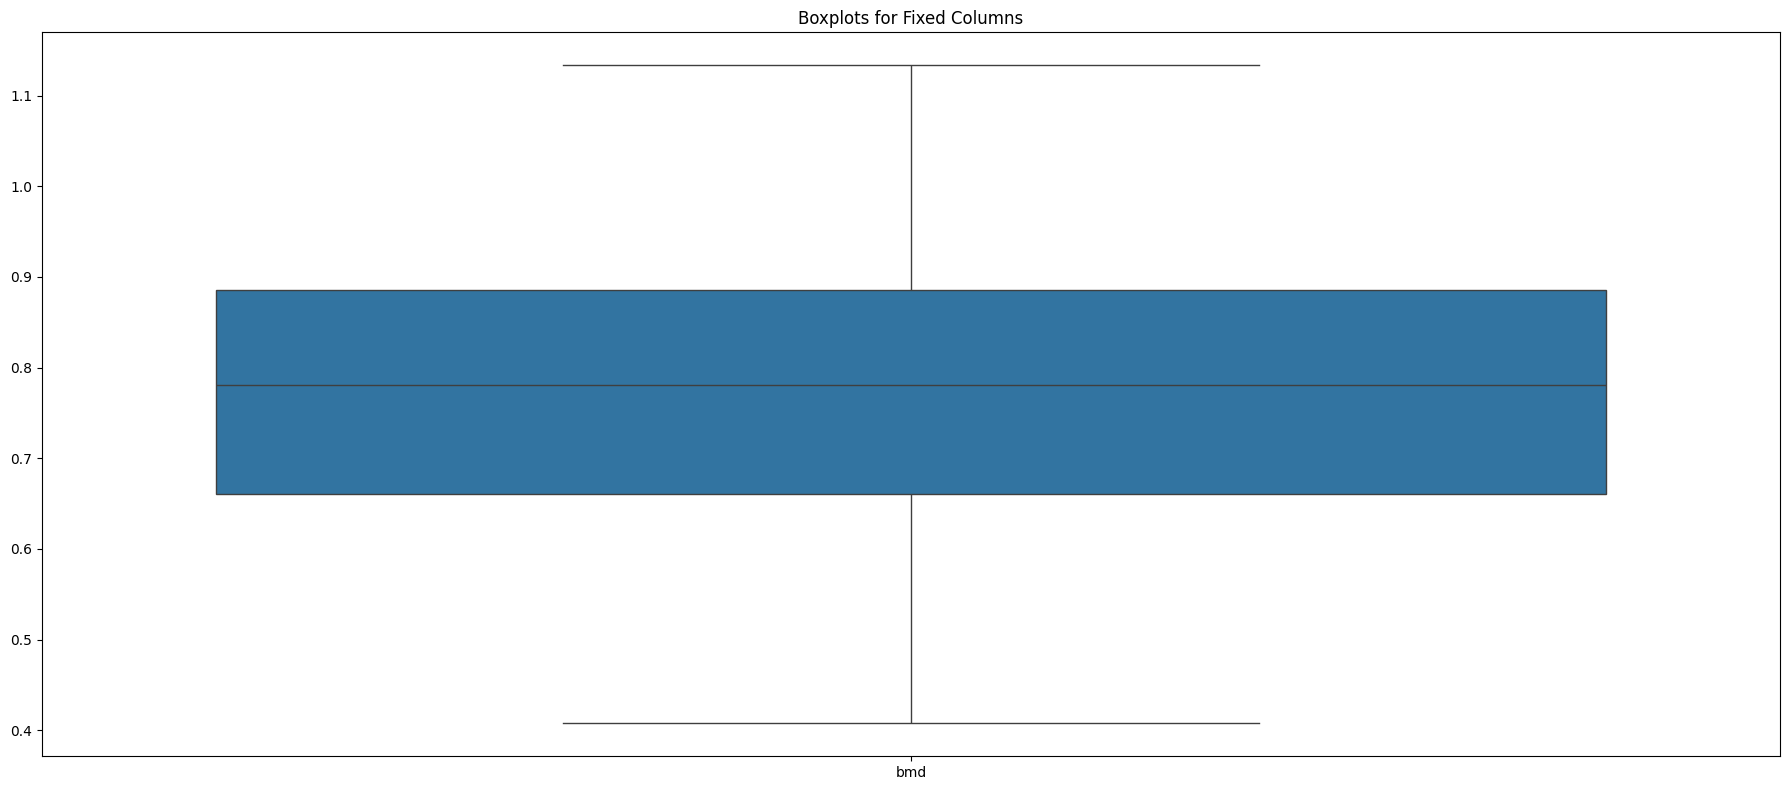

In [10]:
# handling outliers using IQR for column:"bmd"

columns_to_plot = ["bmd"]

for col in columns_to_plot:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

plt.figure(figsize=(18, 8))
sns.boxplot(data=data[columns_to_plot])
plt.title("Boxplots for Fixed Columns")
plt.tight_layout()
plt.show()


## 6. Encodoing data ##
**what we do here**
- use label encoding
- use one hot encoding
- compare to know which one is better in our case

**6.1. Label Encoding**
**what we do here:**
- Encode numeric values for categorical columns (fracture, medication and sex)
- Ensure their count matches when the columns were non-numerical

In [11]:
# Label Encoding for categorical columns
encoder = LabelEncoder()
data['fracture'] = encoder.fit_transform(data['fracture'])
data['medication'] = encoder.fit_transform(data['medication'])
data["sex"] = encoder.fit_transform(data["sex"])
data.head()

,id,age,sex,fracture,weight_kg,height_cm,medication,bmd
0,469,57.052768,0,1,64.0,155.5,0,0.8793
1,8724,75.741225,0,1,78.0,162.0,2,0.7946
2,6736,70.778900,1,1,73.0,170.5,2,0.9067
3,24180,78.247175,0,1,60.0,148.0,2,0.7112
4,17072,54.191877,1,1,55.0,161.0,2,0.7909


Label Encoding Results:
Test Mean Squared Error: 0.0104
Test R^2 Score: 0.4869


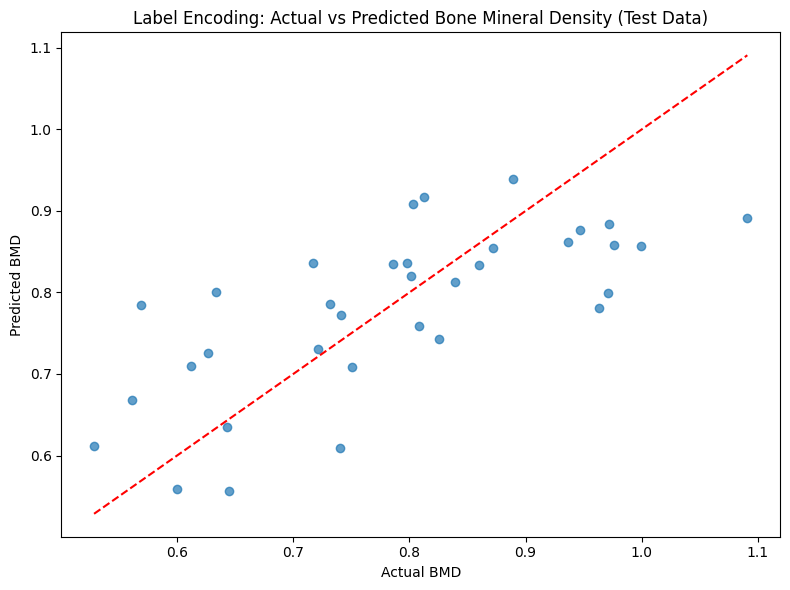

In [12]:
# Split features and target for Label Encoding
x = data.drop("bmd", axis=1)
y = data["bmd"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate Label Encoding model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

# Calculate metrics for Label Encoding
mse_test = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print("Label Encoding Results:")
print(f"Test Mean Squared Error: {mse_test:.4f}")
print(f"Test R^2 Score: {r2_test:.4f}")

# Plot actual vs predicted for Label Encoding
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual BMD")
plt.ylabel("Predicted BMD")
plt.title("Label Encoding: Actual vs Predicted Bone Mineral Density (Test Data)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()

**6.2 One hot enconding**

One-Hot Encoding Results:
Test Mean Squared Error: 0.0102
Test R^2 Score: 0.4952


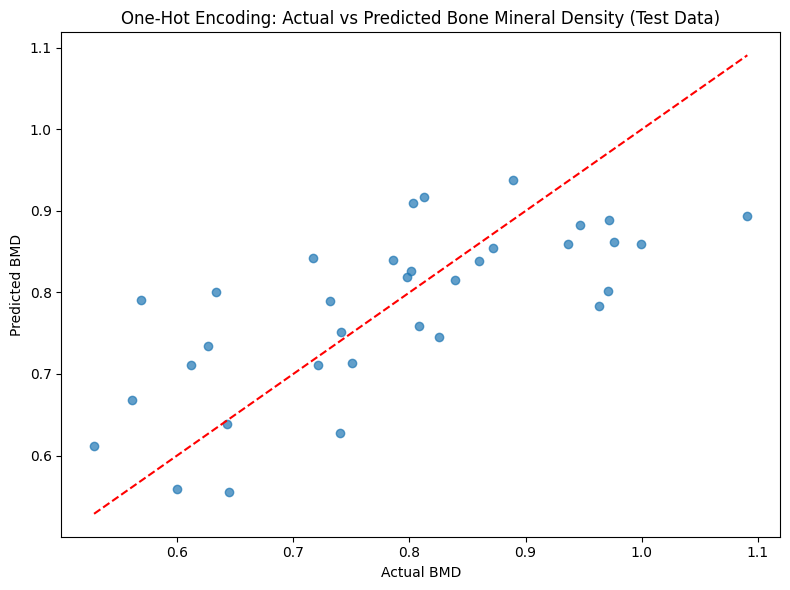

In [13]:
# One-Hot Encoding for categorical columns
data_ohe = pd.get_dummies(data, columns=['fracture', 'medication', 'sex'])

# Split features and target
x_ohe = data_ohe.drop("bmd", axis=1)
y_ohe = data_ohe["bmd"]
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(x_ohe, y_ohe, test_size=0.2, random_state=RANDOM_STATE)

# Scale Data 
scaler = StandardScaler()
X_train_ohe_scaled = scaler.fit_transform(X_train_ohe)
X_test_ohe_scaled = scaler.transform(X_test_ohe)

# Train and evaluate model
lr_ohe = LinearRegression()
lr_ohe.fit(X_train_ohe_scaled, y_train_ohe)
y_pred_ohe = lr_ohe.predict(X_test_ohe_scaled)

# Calculate metrics for One-Hot Encoding
mse_test_ohe = mean_squared_error(y_test_ohe, y_pred_ohe)
r2_test_ohe = r2_score(y_test_ohe, y_pred_ohe)

# Print One-Hot Encoding Results
print("One-Hot Encoding Results:")
print(f"Test Mean Squared Error: {mse_test_ohe:.4f}")
print(f"Test R^2 Score: {r2_test_ohe:.4f}")

# Plot actual vs predicted for One-Hot Encoding
plt.figure(figsize=(8,6))
plt.scatter(y_test_ohe, y_pred_ohe, alpha=0.7)
plt.xlabel("Actual BMD")
plt.ylabel("Predicted BMD")
plt.title("One-Hot Encoding: Actual vs Predicted Bone Mineral Density (Test Data)")
plt.plot([y_test_ohe.min(), y_test_ohe.max()], [y_test_ohe.min(), y_test_ohe.max()], 'r--')
plt.tight_layout()
plt.show()

**6.3 Model Performance Comparison**
**what we do here**
- Comparing Label Encoding vs One-Hot Encoding based on:
- Mean Squared Error (MSE) - Lower is better
- R² Score - Higher is better (closer to 1)

In [14]:
#comparison of both encoding methods
print("=== Performance Comparison ===")
print("\nLabel Encoding:")
print(f"MSE: {mse_test:.4f}")
print(f"R²:  {r2_test:.4f}")

print("\nOne-Hot Encoding:")
print(f"MSE: {mse_test_ohe:.4f}")
print(f"R²:  {r2_test_ohe:.4f}")

# Determine which method is better
print("\n=== Conclusion ===")
if mse_test_ohe < mse_test:
    print("One-Hot Encoding performed better")
elif mse_test_ohe > mse_test:
    print("Label Encoding performed better")
else:
    print("Both methods performed similarly")

=== Performance Comparison ===

Label Encoding:
MSE: 0.0104
R²:  0.4869

One-Hot Encoding:
MSE: 0.0102
R²:  0.4952

=== Conclusion ===
One-Hot Encoding performed better


## 7. Linear regression vs polynomial from previous assignment ##

Linear regression on it's own

Train Mean Squared Error: 0.0099
Train R^2 Score: 0.6141
Test Mean Squared Error: 0.0102
Test R^2 Score: 0.4952


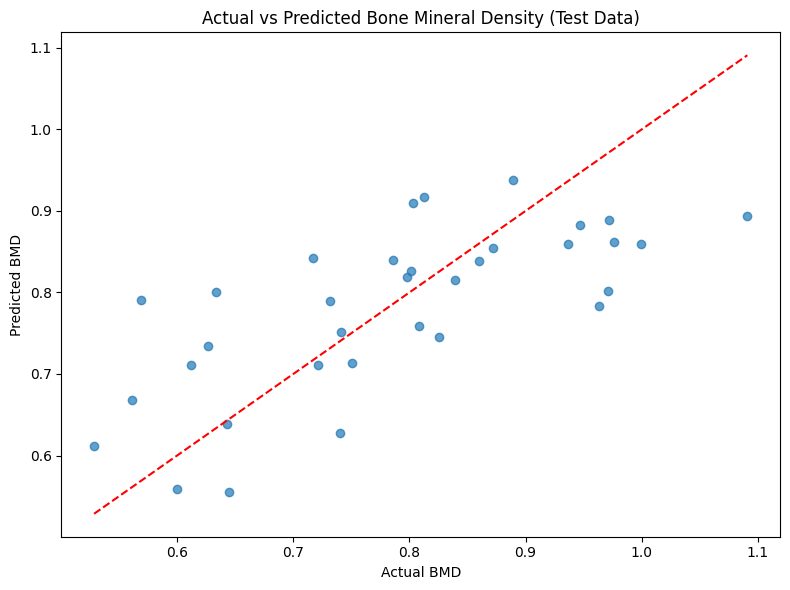

Model is likely underfitting (low R^2 on test set)


In [15]:
# 7. Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score 

# Initialize and train the model 
lr = LinearRegression()
lr.fit(X_train_ohe_scaled, y_train_ohe) 

# Predict on train and test data
y_train_pred = lr.predict(X_train_ohe_scaled)
y_pred = lr.predict(X_test_ohe_scaled) 

# Evaluate the model
mse_train = mean_squared_error(y_train_ohe, y_train_pred)
r2_train = r2_score(y_train_ohe, y_train_pred)
print(f"Train Mean Squared Error: {mse_train:.4f}") 
print(f"Train R^2 Score: {r2_train:.4f}") 
mse_test = mean_squared_error(y_test_ohe, y_pred)
r2_test = r2_score(y_test_ohe, y_pred) 
print(f"Test Mean Squared Error: {mse_test:.4f}") 
print(f"Test R^2 Score: {r2_test:.4f}") 

#Plot actual vs predicted (test only)
plt.figure(figsize=(8,6))
plt.scatter(y_test_ohe, y_pred, alpha=0.7)
plt.xlabel("Actual BMD")
plt.ylabel("Predicted BMD")
plt.title("Actual vs Predicted Bone Mineral Density (Test Data)")
plt.plot([y_test_ohe.min(), y_test_ohe.max()], [y_test_ohe.min(), y_test_ohe.max()], 'r--')
plt.tight_layout()
plt.show() 

# Simple overfitting/underfitting check
if r2_test < 0.5:
    print("Model is likely underfitting (low R^2 on test set)")
elif r2_test > 0.95:
    print("Model may be overfitting (very high R^2 on test set, check train/test gap)")
else:
    print("Model generalizes well (R^2 in reasonable range)")

Now linear vs polynomial with data scaling

Linear Regression:
  R² (Train): 0.614
  R² (Test):  0.495
  RMSE:       0.101
----------------------------------------


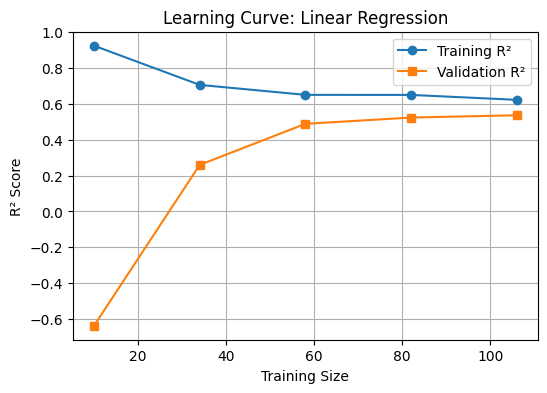

Polynomial Regression (deg=3):
  R² (Train): 0.895
  R² (Test):  -0.769
  RMSE:       0.189
----------------------------------------


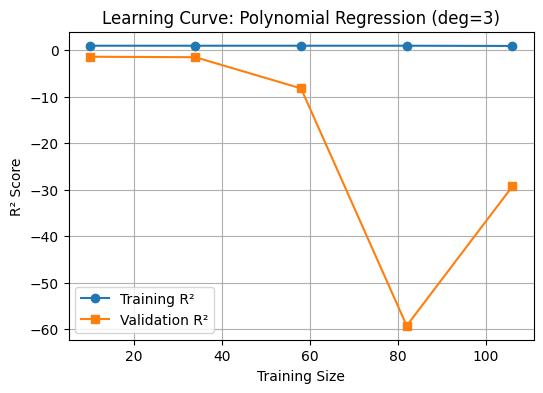


Model Comparison:
                            Model  R2_Train   R2_Test      RMSE
0              Linear Regression  0.614087  0.495227  0.100989
1  Polynomial Regression (deg=3)  0.895294 -0.768966  0.189054

Best Performing Model:
Model       Linear Regression
R2_Train             0.614087
R2_Test              0.495227
RMSE                 0.100989
Name: 0, dtype: object

Overfitting/Underfitting Check:
Linear Regression → Likely Overfitting (ΔR² = 0.12)
Polynomial Regression (deg=3) → Likely Overfitting (ΔR² = 1.66)


In [16]:

# Helper Functions
def evaluate_model(model, X_train, y_train, X_test, y_test, name):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    print(f"{name}:")
    print(f"  R² (Train): {train_r2:.3f}")
    print(f"  R² (Test):  {test_r2:.3f}")
    print(f"  RMSE:       {rmse:.3f}")
    print("-" * 40)
    
    return {
        "Model": name,
        "R2_Train": train_r2,
        "R2_Test": test_r2,
        "RMSE": rmse
    }

def plot_learning_curve(model, X, y, title):
    """Plot learning curve for given model."""
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 5)
    )
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)
    
    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, train_mean, label='Training R²', marker='o')
    plt.plot(train_sizes, val_mean, label='Validation R²', marker='s')
    plt.xlabel('Training Size')
    plt.ylabel('R² Score')
    plt.title(f'Learning Curve: {title}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Train and Compare Models
results = []

models = [
    ("Linear Regression", LinearRegression(), X_train_ohe_scaled, X_test_ohe_scaled),
    ("Polynomial Regression (deg=3)",
     LinearRegression(),
     PolynomialFeatures(degree=3).fit_transform(X_train_ohe_scaled),
     PolynomialFeatures(degree=3).fit_transform(X_test_ohe_scaled)),
]

for name, model, Xtr, Xte in models:
    res = evaluate_model(model, Xtr, y_train_ohe, Xte, y_test_ohe, name)
    results.append(res)
    # Plot learning curve for each model
    plot_learning_curve(model, Xtr, y_train_ohe, name)


# Compare Results
results_df = pd.DataFrame(results)
print("\nModel Comparison:\n", results_df)

# Identify Best Model
best_model = results_df.loc[results_df['R2_Test'].idxmax()]
print("\nBest Performing Model:")
print(best_model)

# Detect Overfitting / Underfitting
print("\nOverfitting/Underfitting Check:")
for row in results:
    diff = row["R2_Train"] - row["R2_Test"]
    if diff > 0.1:
        print(f"{row['Model']} → Likely Overfitting (ΔR² = {diff:.2f})")
    elif diff < -0.05:
        print(f"{row['Model']} → Likely Underfitting (ΔR² = {diff:.2f})")
    else:
        print(f"{row['Model']} → Well Balanced (ΔR² = {diff:.2f})")


Linear regression is generalizing considerably well though, slight overfitting

## 8. Classification models ##

**what we do here**
- create a new train data.
- create new test data to predict whether there will be fracture or not.
- use both train and test with a logistic regression model to predict fracture.
- use SVM model on new train and test data
- evaluate performance of both models



In [17]:
data_ohe_classification = pd.get_dummies(data, columns=['medication', 'sex'])
variables = data_ohe_classification.drop('fracture', axis=1)
target = data_ohe_classification['fracture']

x_fracture_train, x_fracture_test, y_fracture_train, y_fracture_test = train_test_split(variables, target, test_size=0.2, random_state=RANDOM_STATE)
print(f"\nX_fracture_train shape: {x_fracture_train.shape}")
print(f"\nX_fracture_test shape: {x_fracture_test.shape}")


X_fracture_train shape: (133, 10)

X_fracture_test shape: (34, 10)


**8.1 Logistic Model**

In [18]:
# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],  
    'class_weight': [None, 'balanced']
}

log_model = LogisticRegression(max_iter=5000)

grid_search = GridSearchCV(log_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(x_fracture_train, y_fracture_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# Predict with best estimator
best_log_model = grid_search.best_estimator_
y_pred_log = best_log_model.predict(x_fracture_test)
print("Logistic Training Successful")

Best Parameters: {'C': 10, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV Score: 0.8876786874593892
Logistic Training Successful



Logistic Regression Model Evaluation:
Accuracy: 0.8529411764705882
Precision: 0.8888888888888888
Recall: 0.9230769230769231
F1 Score: 0.9056603773584906

Confusion Matrix:
 [[ 5  3]
 [ 2 24]]

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       0.89      0.92      0.91        26

    accuracy                           0.85        34
   macro avg       0.80      0.77      0.79        34
weighted avg       0.85      0.85      0.85        34

AUC: 0.8846153846153847


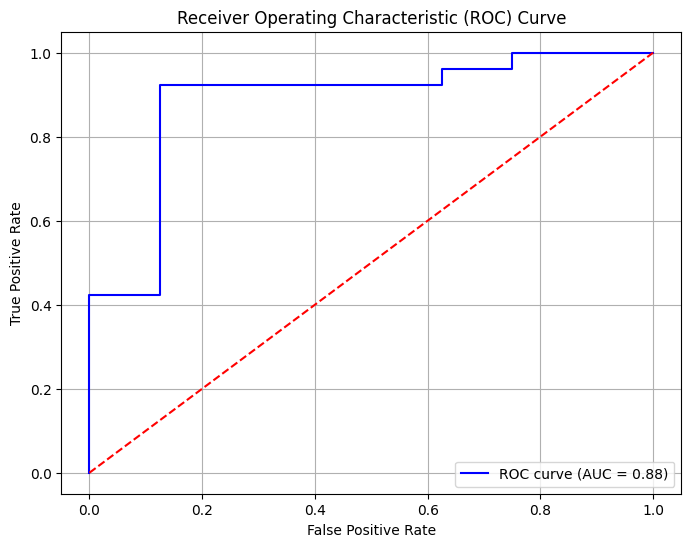

In [19]:
print("\nLogistic Regression Model Evaluation:")

print("Accuracy:", accuracy_score(y_fracture_test, y_pred_log))
print("Precision:", precision_score(y_fracture_test, y_pred_log))
print("Recall:", recall_score(y_fracture_test, y_pred_log))
print("F1 Score:", f1_score(y_fracture_test, y_pred_log))
print("\nConfusion Matrix:\n", confusion_matrix(y_fracture_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_fracture_test, y_pred_log))

y_pred_prob = best_log_model.predict_proba(x_fracture_test)[:, 1]  
fpr, tpr, thresholds = roc_curve(y_fracture_test, y_pred_prob)
auc_score = roc_auc_score(y_fracture_test, y_pred_prob)
print("AUC:", auc_score)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**8.2 SVM model**


=== Testing SVM with C=0.1 ===
Accuracy: 0.5294, Precision: 0.7273, Recall: 0.6154, F1 Score: 0.6667, ROC-AUC: 0.3750

=== Testing SVM with C=1 ===
Accuracy: 0.5882, Precision: 0.7500, Recall: 0.6923, F1 Score: 0.7200, ROC-AUC: 0.3654

=== Testing SVM with C=10 ===
Accuracy: 0.5294, Precision: 0.7273, Recall: 0.6154, F1 Score: 0.6667, ROC-AUC: 0.2933

=== Testing SVM with C=100 ===
Accuracy: 0.5294, Precision: 0.7273, Recall: 0.6154, F1 Score: 0.6667, ROC-AUC: 0.4038

===== SVM Performance Across C Values =====

       C  Accuracy  Precision    Recall  F1 Score   ROC-AUC
0    0.1  0.529412   0.727273  0.615385  0.666667  0.375000
1    1.0  0.588235   0.750000  0.692308  0.720000  0.365385
2   10.0  0.529412   0.727273  0.615385  0.666667  0.293269
3  100.0  0.529412   0.727273  0.615385  0.666667  0.403846


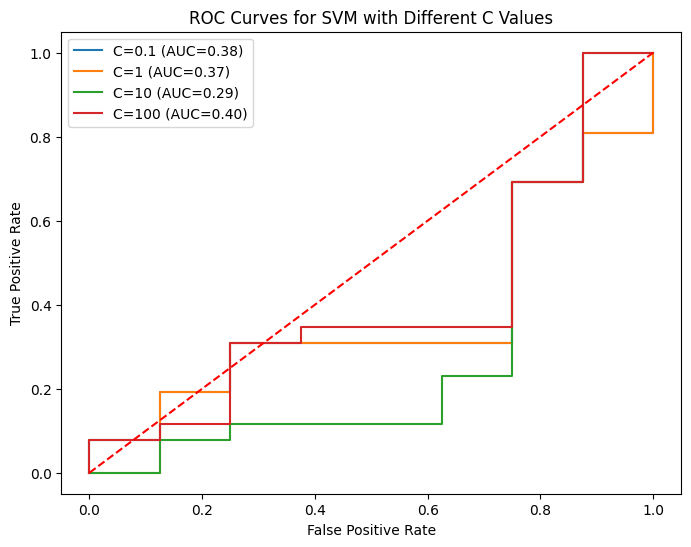

In [20]:
C_values = [0.1, 1, 10, 100]

results = []

for C in C_values:
    print(f"\n=== Testing SVM with C={C} ===")

    svm_model = SVC(C=C, kernel='rbf', class_weight='balanced', probability=True,  gamma='scale' )
    svm_model.fit(x_fracture_train, y_fracture_train)
    
    y_pred_hard = svm_model.predict(x_fracture_test)
    y_proba_soft = svm_model.predict_proba(x_fracture_test)[:, 1]
    
    # Metrics for hard predictions
    acc = accuracy_score(y_fracture_test, y_pred_hard)
    prec = precision_score(y_fracture_test, y_pred_hard)
    rec = recall_score(y_fracture_test, y_pred_hard)
    f1 = f1_score(y_fracture_test, y_pred_hard)
    
    # Metric for soft predictions
    roc_auc = roc_auc_score(y_fracture_test, y_proba_soft)

    results.append({
        "C": C,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "ROC-AUC": roc_auc
    })

    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")

results_df = pd.DataFrame(results)
print("\n===== SVM Performance Across C Values =====\n")
print(results_df)


plt.figure(figsize=(8,6))
for r in results:
    C = r['C']
    svm_model = SVC(C=C, kernel='rbf', class_weight='balanced', probability=True)
    svm_model.fit(x_fracture_train, y_fracture_train)
    y_proba_soft = svm_model.predict_proba(x_fracture_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_fracture_test, y_proba_soft)
    auc_score = roc_auc_score(y_fracture_test, y_proba_soft)
    plt.plot(fpr, tpr, label=f"C={C} (AUC={auc_score:.2f})")

plt.plot([0,1], [0,1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for SVM with Different C Values")
plt.legend()
plt.show()

very low auc due to imbalanced dataset, smote might introduce noise though

**8.3 Comparison between Logistic and SVM**

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Store metrics
metrics = {
    "Accuracy": [
        accuracy_score(y_fracture_test, y_pred_log),
        accuracy_score(y_fracture_test, y_pred_hard)
    ],
    "Precision": [
        precision_score(y_fracture_test, y_pred_log),
        precision_score(y_fracture_test, y_pred_hard)
    ],
    "Recall": [
        recall_score(y_fracture_test, y_pred_log),
        recall_score(y_fracture_test, y_pred_hard)
    ],
    "F1 Score": [
        f1_score(y_fracture_test, y_pred_log),
        f1_score(y_fracture_test, y_pred_hard)
    ],
    "ROC-AUC": [
        roc_auc_score(y_fracture_test, y_pred_log),
        roc_auc_score(y_fracture_test, y_pred_hard)
    ]
}

models = ["Logistic Regression", "SVM (RBF Kernel)"]

comparison_df = pd.DataFrame(metrics, index=models)
print("\n===== MODEL PERFORMANCE COMPARISON =====\n")
print(comparison_df)

# Decide which model is better
# Priority: F1 Score (balanced), then Recall (clinical), then Accuracy, then ROC-AUC
log_score = (comparison_df.loc["Logistic Regression", "F1 Score"] * 0.4 +
             comparison_df.loc["Logistic Regression", "Recall"] * 0.25 +
             comparison_df.loc["Logistic Regression", "Accuracy"] * 0.2 +
             comparison_df.loc["Logistic Regression", "ROC-AUC"] * 0.15)

svm_score = (comparison_df.loc["SVM (RBF Kernel)", "F1 Score"] * 0.4 +
             comparison_df.loc["SVM (RBF Kernel)", "Recall"] * 0.25 +
             comparison_df.loc["SVM (RBF Kernel)", "Accuracy"] * 0.2 +
             comparison_df.loc["SVM (RBF Kernel)", "ROC-AUC"] * 0.15)

print("\n===== MODEL SELECTION RESULT =====\n")

if log_score > svm_score:
    best_model = "Logistic Regression"
else:
    best_model = "SVM"

print(f"Best Model: {best_model}\n")

# Explanation generator
def explain_results(best_model, comparison_df):
    log = comparison_df.loc["Logistic Regression"]
    svm = comparison_df.loc["SVM (RBF Kernel)"]

    print("===== CONCLUSION =====")

    if best_model == "Logistic Regression":
        print(
            f"""
Logistic Regression outperformed the SVM model.

Reasons:
- Higher Accuracy ({log['Accuracy']:.2f} vs {svm['Accuracy']:.2f})
- Higher Recall ({log['Recall']:.2f} vs {svm['Recall']:.2f})
- Higher F1 Score ({log['F1 Score']:.2f} vs {svm['F1 Score']:.2f})
- Higher ROC-AUC ({log['ROC-AUC']:.2f} vs {svm['ROC-AUC']:.2f})
            """
        )
    else:
        print(
            f"""
The SVM model outperformed Logistic Regression.

Reasons:
- Higher Accuracy ({svm['Accuracy']:.2f} vs {log['Accuracy']:.2f})
- Higher Recall ({svm['Recall']:.2f} vs {log['Recall']:.2f})
- Higher F1 Score ({svm['F1 Score']:.2f} vs {log['F1 Score']:.2f})
- Higher ROC-AUC ({svm['ROC-AUC']:.2f} vs {log['ROC-AUC']:.2f})
            """
        )

explain_results(best_model, comparison_df)



===== MODEL PERFORMANCE COMPARISON =====

                     Accuracy  Precision    Recall  F1 Score   ROC-AUC
Logistic Regression  0.852941   0.888889  0.923077  0.905660  0.774038
SVM (RBF Kernel)     0.529412   0.727273  0.615385  0.666667  0.432692

===== MODEL SELECTION RESULT =====

Best Model: Logistic Regression

===== CONCLUSION =====

Logistic Regression outperformed the SVM model.

Reasons:
- Higher Accuracy (0.85 vs 0.53)
- Higher Recall (0.92 vs 0.62)
- Higher F1 Score (0.91 vs 0.67)
- Higher ROC-AUC (0.77 vs 0.43)
            


**8.4 Naive Bayes**
**what we do here**
- use data prepared for fracture classification 
- apply Naive Bayes model

In [22]:
scaler = StandardScaler()
X_train_c_scaled = scaler.fit_transform(x_fracture_train)
X_test_c_scaled = scaler.transform(x_fracture_test)
nb_model = GaussianNB()
nb_model.fit(X_train_c_scaled, y_fracture_train)
y_pred_nb = nb_model.predict(X_test_c_scaled)

print("=== Naive Bayes Performance ===")
print("Accuracy:", accuracy_score(y_fracture_test, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_fracture_test, y_pred_nb))

=== Naive Bayes Performance ===
Accuracy: 0.7941176470588235

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.50      0.53         8
           1       0.85      0.88      0.87        26

    accuracy                           0.79        34
   macro avg       0.71      0.69      0.70        34
weighted avg       0.79      0.79      0.79        34



**8.5 Decision Tree**

In [23]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(x_fracture_train, y_fracture_train) 
y_pred_dt = dt_model.predict(x_fracture_test)

print("\n=== Decision Tree (Default) Performance ===")
print("Accuracy:", accuracy_score(y_fracture_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_fracture_test, y_pred_dt))


=== Decision Tree (Default) Performance ===
Accuracy: 0.9117647058823529

Classification Report:
               precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       1.00      0.88      0.94        26

    accuracy                           0.91        34
   macro avg       0.86      0.94      0.89        34
weighted avg       0.94      0.91      0.92        34



**8.6 How depth of DT affects accuracy**

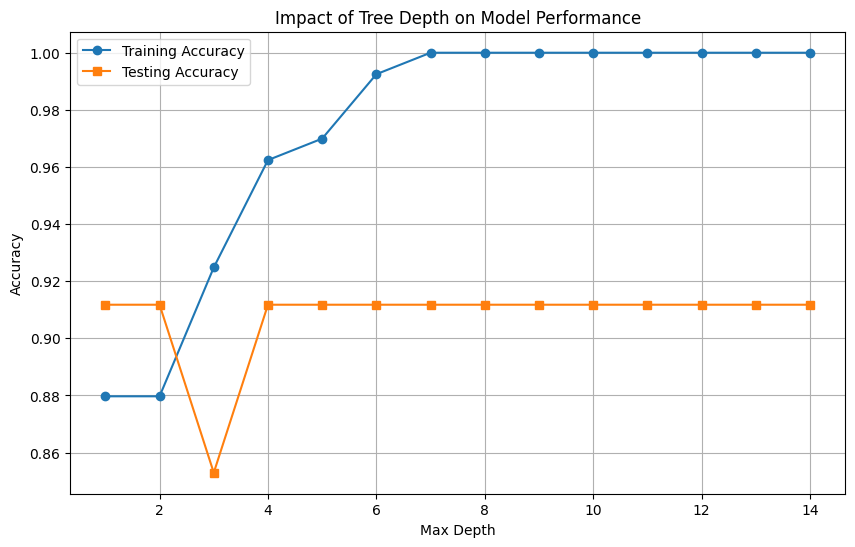

In [24]:
# Experimenting with Tree Depth
train_accuracies = []
test_accuracies = []
depths = range(1, 15)

for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(x_fracture_train, y_fracture_train)
    
    train_accuracies.append(accuracy_score(y_fracture_train, dt.predict(x_fracture_train)))
    test_accuracies.append(accuracy_score(y_fracture_test, dt.predict(x_fracture_test)))

# Plotting the impact
plt.figure(figsize=(10, 6))
plt.plot(depths, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(depths, test_accuracies, label='Testing Accuracy', marker='s')
plt.title('Impact of Tree Depth on Model Performance')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## 9. Ensemble Learning: Gradient Boosting vs Random Forest

**what we do here:**
- Apply Gradient Boosting Classifier on fracture prediction
- Apply Random Forest Classifier on fracture prediction
- Compare performance metrics between both models
- Draw and compare ROC curves


In [25]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Initialize models
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=RANDOM_STATE)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=RANDOM_STATE)

# Train Gradient Boosting
gb_model.fit(x_fracture_train, y_fracture_train)
y_pred_gb = gb_model.predict(x_fracture_test)
y_pred_prob_gb = gb_model.predict_proba(x_fracture_test)[:, 1]

# Train Random Forest
rf_model.fit(x_fracture_train, y_fracture_train)
y_pred_rf = rf_model.predict(x_fracture_test)
y_pred_prob_rf = rf_model.predict_proba(x_fracture_test)[:, 1]

print("Models trained successfully!")


Models trained successfully!


In [26]:
print("\n===== GRADIENT BOOSTING PERFORMANCE =====\n")
print("Accuracy:", accuracy_score(y_fracture_test, y_pred_gb))
print("Precision:", precision_score(y_fracture_test, y_pred_gb))
print("Recall:", recall_score(y_fracture_test, y_pred_gb))
print("F1 Score:", f1_score(y_fracture_test, y_pred_gb))
print("ROC-AUC:", roc_auc_score(y_fracture_test, y_pred_prob_gb))
print("\nConfusion Matrix:\n", confusion_matrix(y_fracture_test, y_pred_gb))
print("\nClassification Report:\n", classification_report(y_fracture_test, y_pred_gb))

print("\n===== RANDOM FOREST PERFORMANCE =====\n")
print("Accuracy:", accuracy_score(y_fracture_test, y_pred_rf))
print("Precision:", precision_score(y_fracture_test, y_pred_rf))
print("Recall:", recall_score(y_fracture_test, y_pred_rf))
print("F1 Score:", f1_score(y_fracture_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_fracture_test, y_pred_prob_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_fracture_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_fracture_test, y_pred_rf))



===== GRADIENT BOOSTING PERFORMANCE =====

Accuracy: 0.8529411764705882
Precision: 0.9565217391304348
Recall: 0.8461538461538461
F1 Score: 0.8979591836734694
ROC-AUC: 0.9134615384615383

Confusion Matrix:
 [[ 7  1]
 [ 4 22]]

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.88      0.74         8
           1       0.96      0.85      0.90        26

    accuracy                           0.85        34
   macro avg       0.80      0.86      0.82        34
weighted avg       0.88      0.85      0.86        34


===== RANDOM FOREST PERFORMANCE =====

Accuracy: 0.9117647058823529
Precision: 0.96
Recall: 0.9230769230769231
F1 Score: 0.9411764705882353
ROC-AUC: 0.9278846153846153

Confusion Matrix:
 [[ 7  1]
 [ 2 24]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.96      0.92      0.94        26

    accuracy             

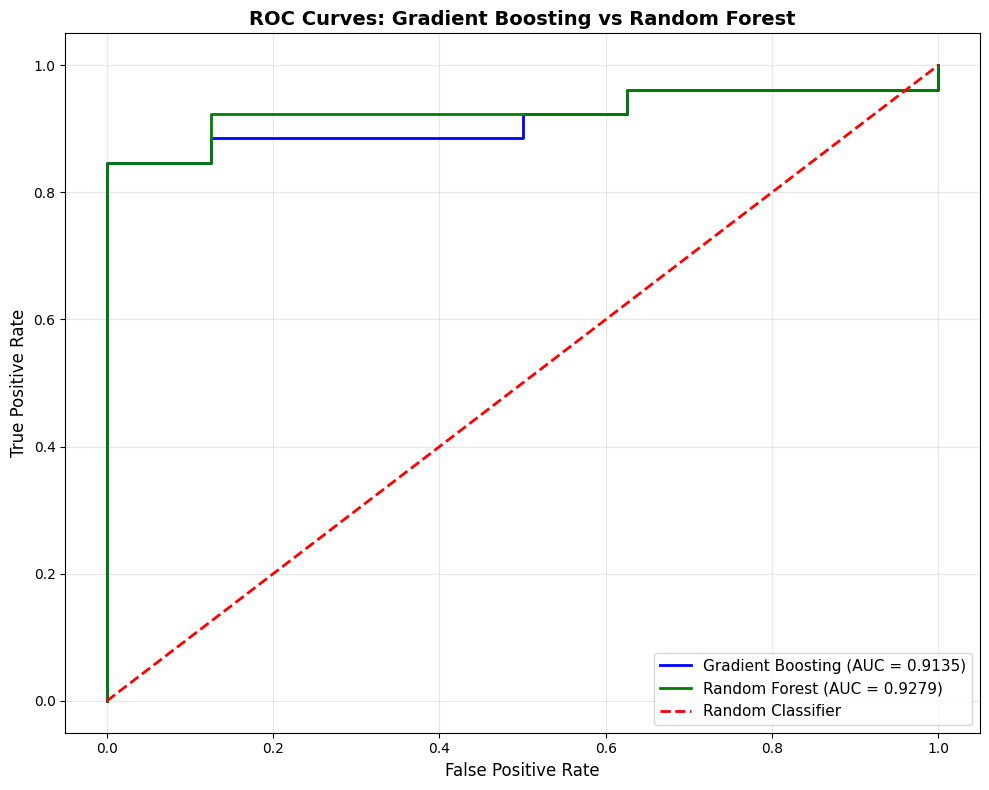

In [27]:
# Plot ROC Curves for both models
fpr_gb, tpr_gb, _ = roc_curve(y_fracture_test, y_pred_prob_gb)
fpr_rf, tpr_rf, _ = roc_curve(y_fracture_test, y_pred_prob_rf)

auc_gb = roc_auc_score(y_fracture_test, y_pred_prob_gb)
auc_rf = roc_auc_score(y_fracture_test, y_pred_prob_rf)

plt.figure(figsize=(10, 8))
plt.plot(fpr_gb, tpr_gb, color='blue', linewidth=2, label=f'Gradient Boosting (AUC = {auc_gb:.4f})')
plt.plot(fpr_rf, tpr_rf, color='green', linewidth=2, label=f'Random Forest (AUC = {auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=2, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves: Gradient Boosting vs Random Forest', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [28]:
# Comprehensive Comparison Table
comparison_metrics = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"],
    "Gradient Boosting": [
        accuracy_score(y_fracture_test, y_pred_gb),
        precision_score(y_fracture_test, y_pred_gb),
        recall_score(y_fracture_test, y_pred_gb),
        f1_score(y_fracture_test, y_pred_gb),
        roc_auc_score(y_fracture_test, y_pred_prob_gb)
    ],
    "Random Forest": [
        accuracy_score(y_fracture_test, y_pred_rf),
        precision_score(y_fracture_test, y_pred_rf),
        recall_score(y_fracture_test, y_pred_rf),
        f1_score(y_fracture_test, y_pred_rf),
        roc_auc_score(y_fracture_test, y_pred_prob_rf)
    ]
}

comparison_df = pd.DataFrame(comparison_metrics)
print("\n===== ENSEMBLE MODELS COMPARISON =====\n")
print(comparison_df.to_string(index=False))

# Determine the better model
gb_total = sum(comparison_df["Gradient Boosting"])
rf_total = sum(comparison_df["Random Forest"])

print(f"\n===== CONCLUSION =====")
print(f"\nGradient Boosting Total Score: {gb_total:.4f}")
print(f"Random Forest Total Score: {rf_total:.4f}")

if gb_total > rf_total:
    print(f"\n✓ Gradient Boosting is the BETTER model")
    print(f"  Advantage: {gb_total - rf_total:.4f}")
else:
    print(f"\n✓ Random Forest is the BETTER model")
    print(f"  Advantage: {rf_total - gb_total:.4f}")

# Feature importance comparison
print("\n===== FEATURE IMPORTANCE (Top 5) =====\n")

gb_importance = pd.DataFrame({
    'Feature': x_fracture_train.columns,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(5)

rf_importance = pd.DataFrame({
    'Feature': x_fracture_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False).head(5)

print("Gradient Boosting - Top 5 Features:")
print(gb_importance.to_string(index=False))

print("\n\nRandom Forest - Top 5 Features:")
print(rf_importance.to_string(index=False))



===== ENSEMBLE MODELS COMPARISON =====

   Metric  Gradient Boosting  Random Forest
 Accuracy           0.852941       0.911765
Precision           0.956522       0.960000
   Recall           0.846154       0.923077
 F1 Score           0.897959       0.941176
  ROC-AUC           0.913462       0.927885

===== CONCLUSION =====

Gradient Boosting Total Score: 4.4670
Random Forest Total Score: 4.6639

✓ Random Forest is the BETTER model
  Advantage: 0.1969

===== FEATURE IMPORTANCE (Top 5) =====

Gradient Boosting - Top 5 Features:
     Feature  Importance
         bmd    0.649412
         age    0.123822
          id    0.064094
medication_2    0.058383
   height_cm    0.054299


Random Forest - Top 5 Features:
  Feature  Importance
      bmd    0.432566
      age    0.156671
weight_kg    0.138954
       id    0.133701
height_cm    0.078381


## 10. Clustering Analysis

### 10.1 K-Means Clustering

**What we do here:**
- Implement K-Means clustering on the dataset
- Experiment with different parameters: n_clusters, init method, n_init, max_iter
- Evaluate using Silhouette Score and Inertia metrics
- Analyze how each parameter affects clustering performance

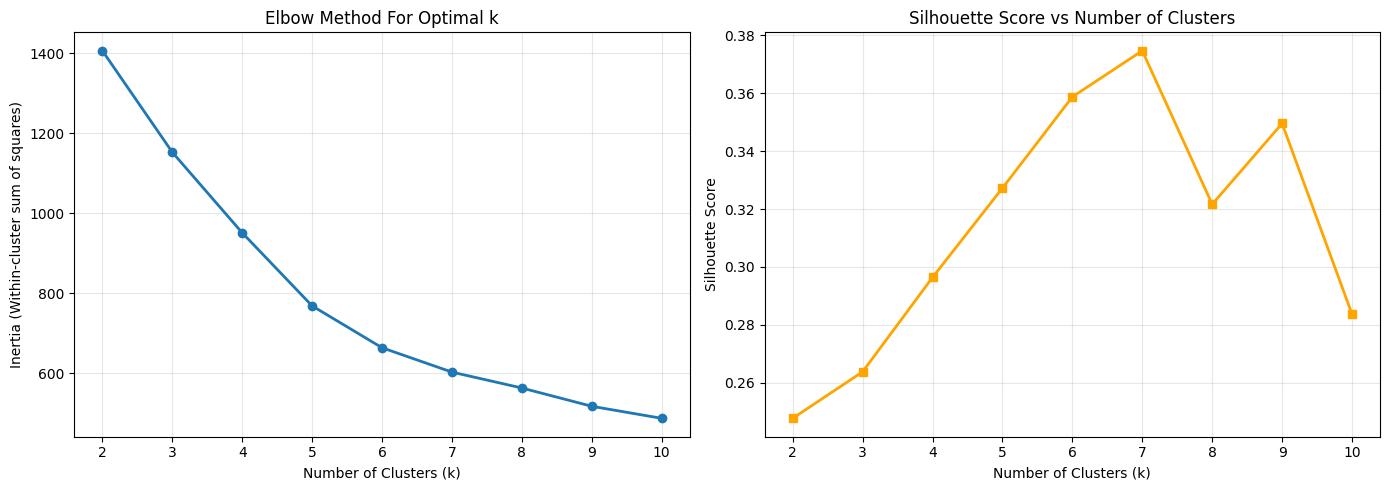

Elbow Method and Silhouette Analysis:
k=2: Inertia=1405.97, Silhouette Score=0.2478
k=3: Inertia=1152.41, Silhouette Score=0.2638
k=4: Inertia=951.21, Silhouette Score=0.2964
k=5: Inertia=768.67, Silhouette Score=0.3272
k=6: Inertia=664.10, Silhouette Score=0.3587
k=7: Inertia=603.24, Silhouette Score=0.3746
k=8: Inertia=563.53, Silhouette Score=0.3216
k=9: Inertia=517.89, Silhouette Score=0.3495
k=10: Inertia=487.77, Silhouette Score=0.2837


In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Prepare data for clustering (using one-hot encoded data)
# Drop BMD (target variable) and use all other features for clustering
X_clustering = data_ohe.drop('bmd', axis=1)
scaler = StandardScaler()
X_clustering_scaled = scaler.fit_transform(X_clustering)

# Test different number of clusters using Elbow Method
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    kmeans.fit(X_clustering_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_clustering_scaled, kmeans.labels_))

# Plot Elbow Method and Silhouette Scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(k_range, inertias, marker='o', linestyle='-', linewidth=2)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)')
axes[0].set_title('Elbow Method For Optimal k')
axes[0].grid(True, alpha=0.3)

axes[1].plot(k_range, silhouette_scores, marker='s', linestyle='-', linewidth=2, color='orange')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score vs Number of Clusters')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Elbow Method and Silhouette Analysis:")
for k, inertia, sil_score in zip(k_range, inertias, silhouette_scores):
    print(f"k={k}: Inertia={inertia:.2f}, Silhouette Score={sil_score:.4f}")


In [31]:
# Experiment 1: Different Initialization Methods (init)
print("\n" + "="*70)
print("EXPERIMENT 1: Impact of Initialization Method (init)")
print("="*70 + "\n")

init_methods = ['k-means++', 'random']
optimal_k = 3  # Based on elbow method and silhouette score

results_init = []

for init_method in init_methods:
    print(f"\nTesting init method: {init_method}")
    print("-" * 50)
    
    kmeans = KMeans(n_clusters=optimal_k, init=init_method, random_state=RANDOM_STATE, n_init=10)
    kmeans.fit(X_clustering_scaled)
    
    sil_score = silhouette_score(X_clustering_scaled, kmeans.labels_)
    db_score = davies_bouldin_score(X_clustering_scaled, kmeans.labels_)
    ch_score = calinski_harabasz_score(X_clustering_scaled, kmeans.labels_)
    
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Davies-Bouldin Score: {db_score:.4f} (lower is better)")
    print(f"Calinski-Harabasz Score: {ch_score:.2f} (higher is better)")
    print(f"Inertia: {kmeans.inertia_:.2f}")
    
    results_init.append({
        'Init Method': init_method,
        'Silhouette Score': sil_score,
        'Davies-Bouldin Score': db_score,
        'Calinski-Harabasz Score': ch_score,
        'Inertia': kmeans.inertia_
    })

results_init_df = pd.DataFrame(results_init)
print("\n" + "="*70)
print("SUMMARY - Initialization Methods Comparison:")
print("="*70)
print(results_init_df.to_string(index=False))



EXPERIMENT 1: Impact of Initialization Method (init)


Testing init method: k-means++
--------------------------------------------------
Silhouette Score: 0.2638
Davies-Bouldin Score: 1.4334 (lower is better)
Calinski-Harabasz Score: 48.71 (higher is better)
Inertia: 1152.41

Testing init method: random
--------------------------------------------------
Silhouette Score: 0.2638
Davies-Bouldin Score: 1.4334 (lower is better)
Calinski-Harabasz Score: 48.71 (higher is better)
Inertia: 1152.41

SUMMARY - Initialization Methods Comparison:
Init Method  Silhouette Score  Davies-Bouldin Score  Calinski-Harabasz Score     Inertia
  k-means++          0.263847              1.433423                48.712045 1152.411011
     random          0.263847              1.433423                48.712045 1152.411011



EXPERIMENT 2: Impact of Number of Initializations (n_init)


Testing n_init: 1
--------------------------------------------------
Silhouette Score: 0.2827
Davies-Bouldin Score: 1.5007
Calinski-Harabasz Score: 41.68
Inertia: 1217.97

Testing n_init: 5
--------------------------------------------------
Silhouette Score: 0.2638
Davies-Bouldin Score: 1.4334
Calinski-Harabasz Score: 48.71
Inertia: 1152.41

Testing n_init: 10
--------------------------------------------------
Silhouette Score: 0.2638
Davies-Bouldin Score: 1.4334
Calinski-Harabasz Score: 48.71
Inertia: 1152.41

Testing n_init: 20
--------------------------------------------------
Silhouette Score: 0.2638
Davies-Bouldin Score: 1.4334
Calinski-Harabasz Score: 48.71
Inertia: 1152.41

Testing n_init: 50
--------------------------------------------------
Silhouette Score: 0.2638
Davies-Bouldin Score: 1.4334
Calinski-Harabasz Score: 48.71
Inertia: 1152.41

SUMMARY - Number of Initializations Comparison:
 n_init  Silhouette Score  

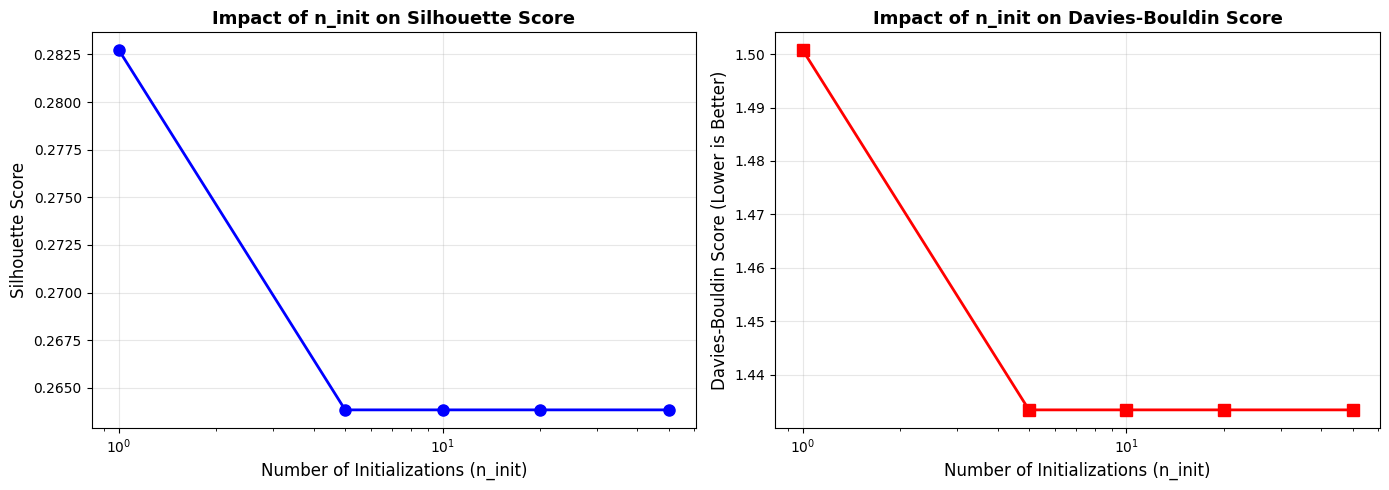

In [32]:
# Experiment 2: Different Number of Runs (n_init)
print("\n" + "="*70)
print("EXPERIMENT 2: Impact of Number of Initializations (n_init)")
print("="*70 + "\n")

n_init_values = [1, 5, 10, 20, 50]

results_n_init = []

for n_init_val in n_init_values:
    print(f"\nTesting n_init: {n_init_val}")
    print("-" * 50)
    
    kmeans = KMeans(n_clusters=optimal_k, init='k-means++', n_init=n_init_val, random_state=RANDOM_STATE)
    kmeans.fit(X_clustering_scaled)
    
    sil_score = silhouette_score(X_clustering_scaled, kmeans.labels_)
    db_score = davies_bouldin_score(X_clustering_scaled, kmeans.labels_)
    ch_score = calinski_harabasz_score(X_clustering_scaled, kmeans.labels_)
    
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Davies-Bouldin Score: {db_score:.4f}")
    print(f"Calinski-Harabasz Score: {ch_score:.2f}")
    print(f"Inertia: {kmeans.inertia_:.2f}")
    
    results_n_init.append({
        'n_init': n_init_val,
        'Silhouette Score': sil_score,
        'Davies-Bouldin Score': db_score,
        'Calinski-Harabasz Score': ch_score,
        'Inertia': kmeans.inertia_
    })

results_n_init_df = pd.DataFrame(results_n_init)
print("\n" + "="*70)
print("SUMMARY - Number of Initializations Comparison:")
print("="*70)
print(results_n_init_df.to_string(index=False))

# Visualize impact of n_init
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(results_n_init_df['n_init'], results_n_init_df['Silhouette Score'], 
             marker='o', linestyle='-', linewidth=2, markersize=8, color='blue')
axes[0].set_xlabel('Number of Initializations (n_init)', fontsize=12)
axes[0].set_ylabel('Silhouette Score', fontsize=12)
axes[0].set_title('Impact of n_init on Silhouette Score', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log')

axes[1].plot(results_n_init_df['n_init'], results_n_init_df['Davies-Bouldin Score'], 
             marker='s', linestyle='-', linewidth=2, markersize=8, color='red')
axes[1].set_xlabel('Number of Initializations (n_init)', fontsize=12)
axes[1].set_ylabel('Davies-Bouldin Score (Lower is Better)', fontsize=12)
axes[1].set_title('Impact of n_init on Davies-Bouldin Score', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log')

plt.tight_layout()
plt.show()



EXPERIMENT 3: Impact of Maximum Iterations (max_iter)


Testing max_iter: 50
--------------------------------------------------
Silhouette Score: 0.2638
Davies-Bouldin Score: 1.4334
Calinski-Harabasz Score: 48.71
Inertia: 1152.41
Number of Iterations: 7

Testing max_iter: 100
--------------------------------------------------
Silhouette Score: 0.2638
Davies-Bouldin Score: 1.4334
Calinski-Harabasz Score: 48.71
Inertia: 1152.41
Number of Iterations: 7

Testing max_iter: 200
--------------------------------------------------
Silhouette Score: 0.2638
Davies-Bouldin Score: 1.4334
Calinski-Harabasz Score: 48.71
Inertia: 1152.41
Number of Iterations: 7

Testing max_iter: 500
--------------------------------------------------
Silhouette Score: 0.2638
Davies-Bouldin Score: 1.4334
Calinski-Harabasz Score: 48.71
Inertia: 1152.41
Number of Iterations: 7

Testing max_iter: 1000
--------------------------------------------------
Silhouette Score: 0.2638
Davies-Bouldin Score: 1.4334
Calinski-Harabas

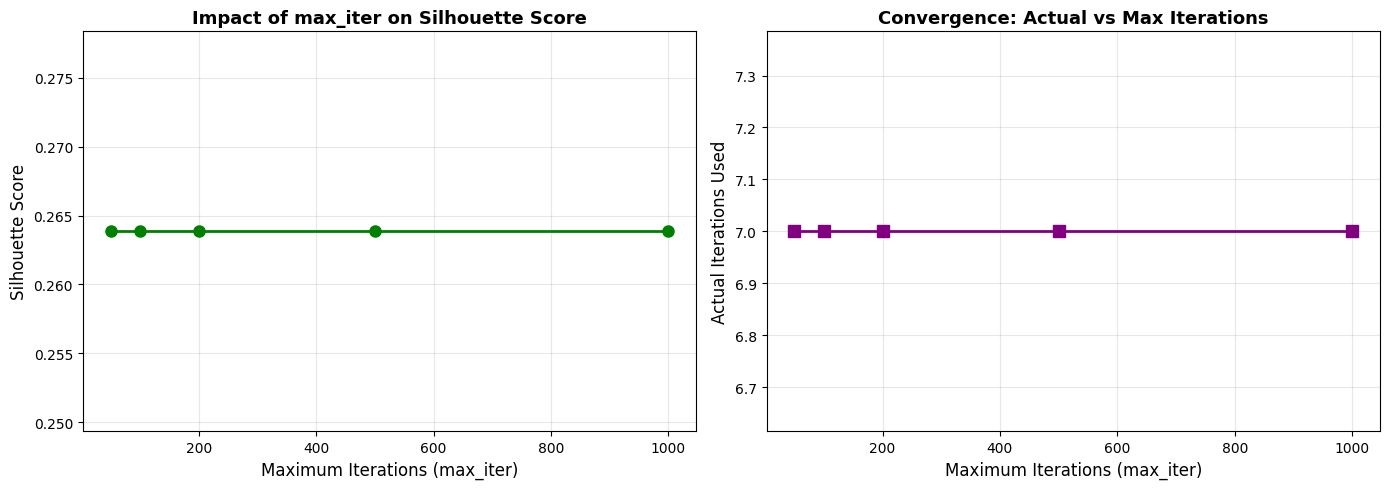

In [33]:
# Experiment 3: Different Maximum Iterations (max_iter)
print("\n" + "="*70)
print("EXPERIMENT 3: Impact of Maximum Iterations (max_iter)")
print("="*70 + "\n")

max_iter_values = [50, 100, 200, 500, 1000]

results_max_iter = []

for max_iter_val in max_iter_values:
    print(f"\nTesting max_iter: {max_iter_val}")
    print("-" * 50)
    
    kmeans = KMeans(n_clusters=optimal_k, init='k-means++', n_init=10, 
                    max_iter=max_iter_val, random_state=RANDOM_STATE)
    kmeans.fit(X_clustering_scaled)
    
    sil_score = silhouette_score(X_clustering_scaled, kmeans.labels_)
    db_score = davies_bouldin_score(X_clustering_scaled, kmeans.labels_)
    ch_score = calinski_harabasz_score(X_clustering_scaled, kmeans.labels_)
    
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Davies-Bouldin Score: {db_score:.4f}")
    print(f"Calinski-Harabasz Score: {ch_score:.2f}")
    print(f"Inertia: {kmeans.inertia_:.2f}")
    print(f"Number of Iterations: {kmeans.n_iter_}")
    
    results_max_iter.append({
        'max_iter': max_iter_val,
        'Silhouette Score': sil_score,
        'Davies-Bouldin Score': db_score,
        'Calinski-Harabasz Score': ch_score,
        'Inertia': kmeans.inertia_,
        'Actual Iterations': kmeans.n_iter_
    })

results_max_iter_df = pd.DataFrame(results_max_iter)
print("\n" + "="*70)
print("SUMMARY - Maximum Iterations Comparison:")
print("="*70)
print(results_max_iter_df.to_string(index=False))

# Visualize impact of max_iter
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(results_max_iter_df['max_iter'], results_max_iter_df['Silhouette Score'], 
             marker='o', linestyle='-', linewidth=2, markersize=8, color='green')
axes[0].set_xlabel('Maximum Iterations (max_iter)', fontsize=12)
axes[0].set_ylabel('Silhouette Score', fontsize=12)
axes[0].set_title('Impact of max_iter on Silhouette Score', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(results_max_iter_df['max_iter'], results_max_iter_df['Actual Iterations'], 
             marker='s', linestyle='-', linewidth=2, markersize=8, color='purple')
axes[1].set_xlabel('Maximum Iterations (max_iter)', fontsize=12)
axes[1].set_ylabel('Actual Iterations Used', fontsize=12)
axes[1].set_title('Convergence: Actual vs Max Iterations', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



EXPERIMENT 4: Impact of Number of Clusters (n_clusters)


Testing n_clusters: 2
--------------------------------------------------
Silhouette Score: 0.2478
Davies-Bouldin Score: 1.6992
Calinski-Harabasz Score: 50.58
Inertia: 1405.97

Testing n_clusters: 3
--------------------------------------------------
Silhouette Score: 0.2638
Davies-Bouldin Score: 1.4334
Calinski-Harabasz Score: 48.71
Inertia: 1152.41

Testing n_clusters: 4
--------------------------------------------------
Silhouette Score: 0.2964
Davies-Bouldin Score: 1.2530
Calinski-Harabasz Score: 50.60
Inertia: 951.21

Testing n_clusters: 5
--------------------------------------------------
Silhouette Score: 0.3272
Davies-Bouldin Score: 1.0978
Calinski-Harabasz Score: 56.29
Inertia: 768.67

Testing n_clusters: 6
--------------------------------------------------
Silhouette Score: 0.3587
Davies-Bouldin Score: 1.0670
Calinski-Harabasz Score: 56.87
Inertia: 664.10

Testing n_clusters: 7
------------------------------------------

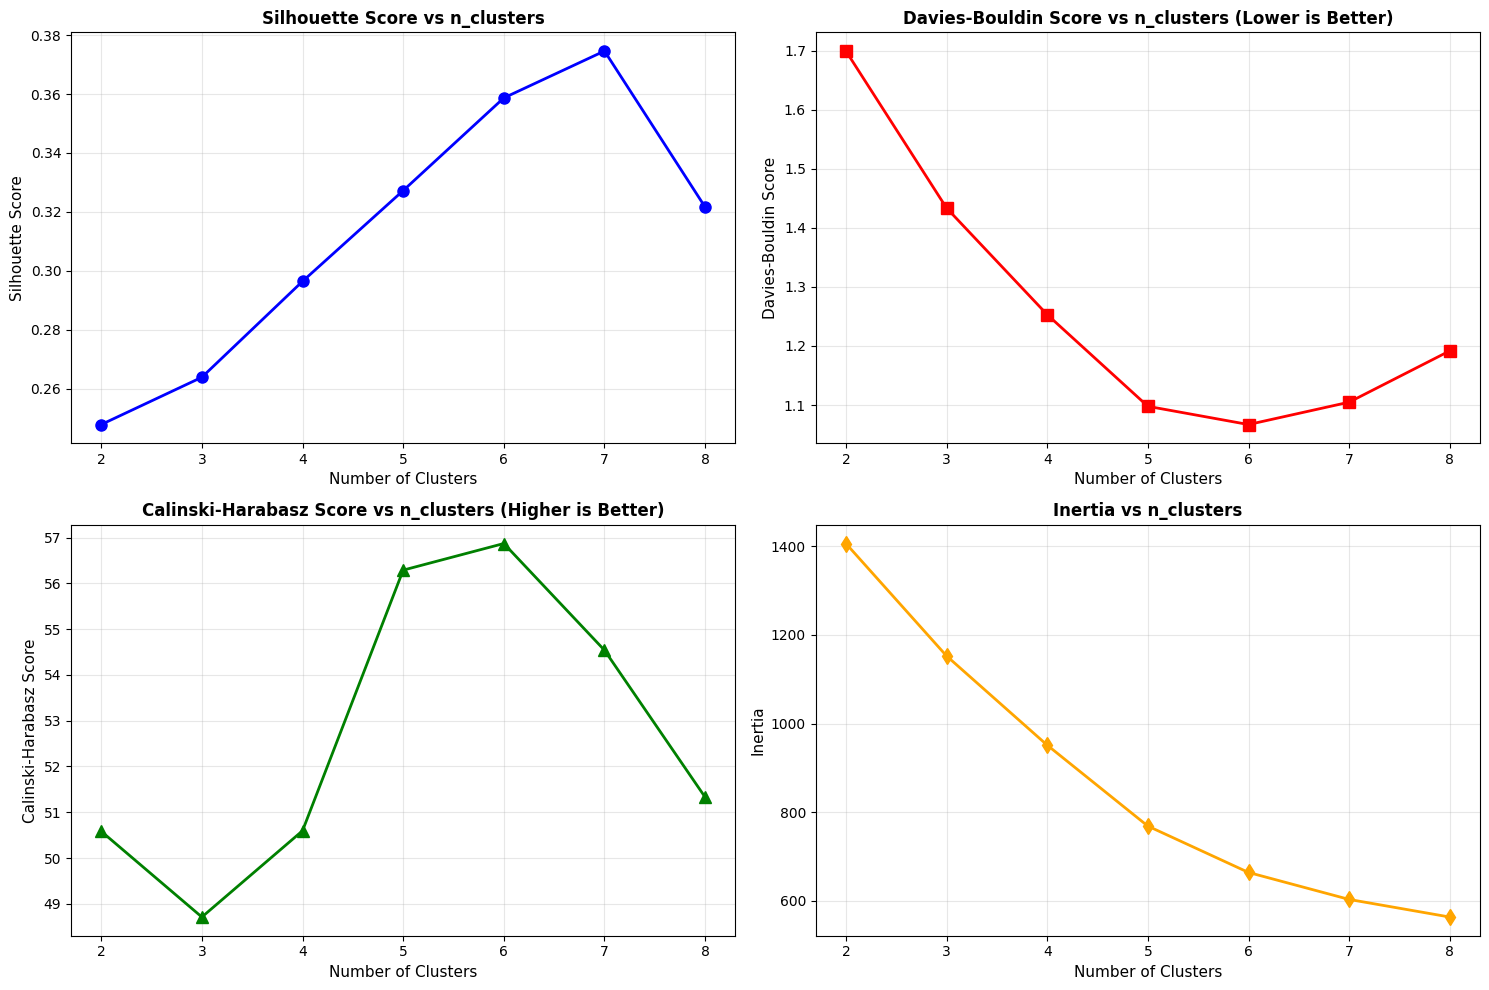


Best k based on Silhouette Score: 7
Best k based on Davies-Bouldin Score: 6
Best k based on Calinski-Harabasz Score: 6


In [34]:
# Experiment 4: Different Number of Clusters (n_clusters) - Comprehensive Analysis
print("\n" + "="*70)
print("EXPERIMENT 4: Impact of Number of Clusters (n_clusters)")
print("="*70 + "\n")

n_clusters_values = [2, 3, 4, 5, 6, 7, 8]

results_n_clusters = []

for n_clusters_val in n_clusters_values:
    print(f"\nTesting n_clusters: {n_clusters_val}")
    print("-" * 50)
    
    kmeans = KMeans(n_clusters=n_clusters_val, init='k-means++', n_init=10, 
                    random_state=RANDOM_STATE)
    kmeans.fit(X_clustering_scaled)
    
    sil_score = silhouette_score(X_clustering_scaled, kmeans.labels_)
    db_score = davies_bouldin_score(X_clustering_scaled, kmeans.labels_)
    ch_score = calinski_harabasz_score(X_clustering_scaled, kmeans.labels_)
    
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Davies-Bouldin Score: {db_score:.4f}")
    print(f"Calinski-Harabasz Score: {ch_score:.2f}")
    print(f"Inertia: {kmeans.inertia_:.2f}")
    
    results_n_clusters.append({
        'n_clusters': n_clusters_val,
        'Silhouette Score': sil_score,
        'Davies-Bouldin Score': db_score,
        'Calinski-Harabasz Score': ch_score,
        'Inertia': kmeans.inertia_
    })

results_n_clusters_df = pd.DataFrame(results_n_clusters)
print("\n" + "="*70)
print("SUMMARY - Number of Clusters Comparison:")
print("="*70)
print(results_n_clusters_df.to_string(index=False))

# Comprehensive visualization of n_clusters impact
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(results_n_clusters_df['n_clusters'], results_n_clusters_df['Silhouette Score'], 
                marker='o', linestyle='-', linewidth=2, markersize=8, color='blue')
axes[0, 0].set_xlabel('Number of Clusters', fontsize=11)
axes[0, 0].set_ylabel('Silhouette Score', fontsize=11)
axes[0, 0].set_title('Silhouette Score vs n_clusters', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(results_n_clusters_df['n_clusters'], results_n_clusters_df['Davies-Bouldin Score'], 
                marker='s', linestyle='-', linewidth=2, markersize=8, color='red')
axes[0, 1].set_xlabel('Number of Clusters', fontsize=11)
axes[0, 1].set_ylabel('Davies-Bouldin Score', fontsize=11)
axes[0, 1].set_title('Davies-Bouldin Score vs n_clusters (Lower is Better)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(results_n_clusters_df['n_clusters'], results_n_clusters_df['Calinski-Harabasz Score'], 
                marker='^', linestyle='-', linewidth=2, markersize=8, color='green')
axes[1, 0].set_xlabel('Number of Clusters', fontsize=11)
axes[1, 0].set_ylabel('Calinski-Harabasz Score', fontsize=11)
axes[1, 0].set_title('Calinski-Harabasz Score vs n_clusters (Higher is Better)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(results_n_clusters_df['n_clusters'], results_n_clusters_df['Inertia'], 
                marker='d', linestyle='-', linewidth=2, markersize=8, color='orange')
axes[1, 1].set_xlabel('Number of Clusters', fontsize=11)
axes[1, 1].set_ylabel('Inertia', fontsize=11)
axes[1, 1].set_title('Inertia vs n_clusters', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nBest k based on Silhouette Score:", 
      results_n_clusters_df.loc[results_n_clusters_df['Silhouette Score'].idxmax(), 'n_clusters'])
print("Best k based on Davies-Bouldin Score:", 
      results_n_clusters_df.loc[results_n_clusters_df['Davies-Bouldin Score'].idxmin(), 'n_clusters'])
print("Best k based on Calinski-Harabasz Score:", 
      results_n_clusters_df.loc[results_n_clusters_df['Calinski-Harabasz Score'].idxmax(), 'n_clusters'])



FINAL K-MEANS CLUSTERING WITH OPTIMAL PARAMETERS

Optimal K-Means Model:
  Number of Clusters: 3
  Initialization: k-means++
  Number of Initializations: 50
  Max Iterations: 500

Performance Metrics:
  Silhouette Score: 0.2638
  Davies-Bouldin Score: 1.4334
  Calinski-Harabasz Score: 48.71
  Inertia: 1152.41
  Actual Iterations: 7

Cluster Distribution:
  Cluster 0: 50 samples (29.9%)
  Cluster 1: 59 samples (35.3%)
  Cluster 2: 58 samples (34.7%)


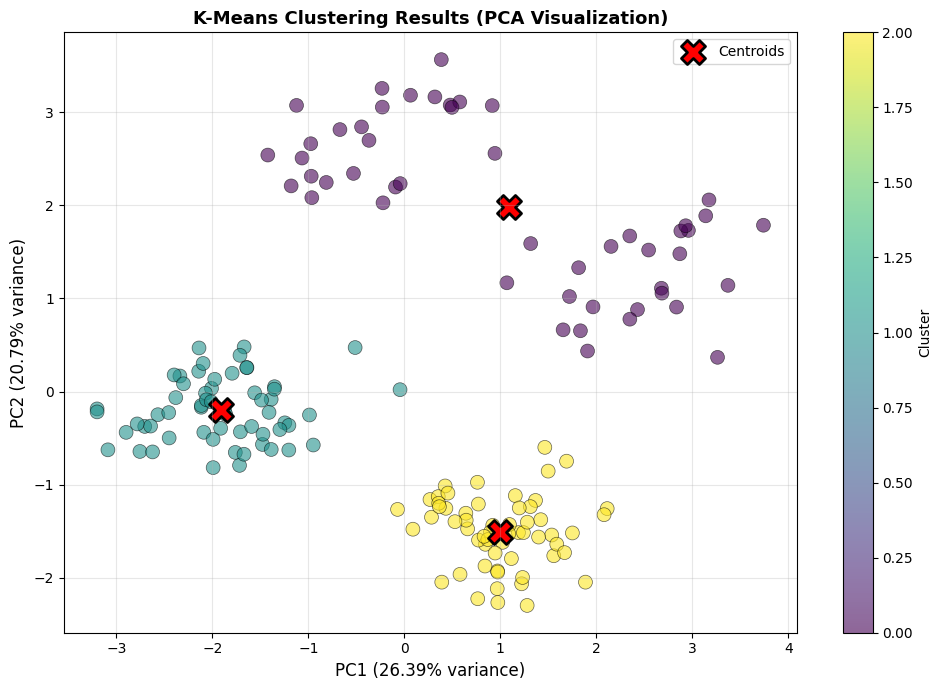

In [35]:
# Final K-Means Summary and Visualization with Optimal Parameters
print("\n" + "="*70)
print("FINAL K-MEANS CLUSTERING WITH OPTIMAL PARAMETERS")
print("="*70 + "\n")

optimal_kmeans = KMeans(n_clusters=3, init='k-means++', n_init=50, 
                        max_iter=500, random_state=RANDOM_STATE)
optimal_kmeans.fit(X_clustering_scaled)

print(f"Optimal K-Means Model:")
print(f"  Number of Clusters: 3")
print(f"  Initialization: k-means++")
print(f"  Number of Initializations: 50")
print(f"  Max Iterations: 500")
print(f"\nPerformance Metrics:")
print(f"  Silhouette Score: {silhouette_score(X_clustering_scaled, optimal_kmeans.labels_):.4f}")
print(f"  Davies-Bouldin Score: {davies_bouldin_score(X_clustering_scaled, optimal_kmeans.labels_):.4f}")
print(f"  Calinski-Harabasz Score: {calinski_harabasz_score(X_clustering_scaled, optimal_kmeans.labels_):.2f}")
print(f"  Inertia: {optimal_kmeans.inertia_:.2f}")
print(f"  Actual Iterations: {optimal_kmeans.n_iter_}")

# Cluster distribution
unique, counts = np.unique(optimal_kmeans.labels_, return_counts=True)
print(f"\nCluster Distribution:")
for cluster_id, count in zip(unique, counts):
    print(f"  Cluster {cluster_id}: {count} samples ({count/len(optimal_kmeans.labels_)*100:.1f}%)")

# Visualize clusters using PCA for 2D representation
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clustering_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=optimal_kmeans.labels_, 
                     cmap='viridis', s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
centers_pca = pca.transform(optimal_kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X', 
           s=300, edgecolors='black', linewidth=2, label='Centroids')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.title('K-Means Clustering Results (PCA Visualization)', fontsize=13, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 10.2 K-Medoids Clustering

**What we do here:**
- Implement K-Medoids clustering (more robust to outliers than K-Means)
- Experiment with different parameters: n_clusters, metric, init method
- Evaluate using the same metrics as K-Means
- Compare performance with K-Means clustering

In [ ]:
# Custom K-Medoids Implementation using scipy
from scipy.spatial.distance import cdist, pdist, squareform

class KMedoids:
    """Simple K-Medoids implementation using scipy"""
    def __init__(self, n_clusters=3, metric='euclidean', init='build', max_iter=100, random_state=None):
        self.n_clusters = n_clusters
        self.metric = metric
        self.init = init
        self.max_iter = max_iter
        self.random_state = random_state
        self.medoid_indices_ = None
        self.labels_ = None
        self.inertia_ = None
        
    def fit(self, X):
        np.random.seed(self.random_state)
        n_samples = X.shape[0]
        
        # Initialize medoids
        if self.init == 'build':
            # Build method: select medoids that minimize total distance
            distances = squareform(pdist(X, metric=self.metric))
            medoid_indices = [np.argmin(distances.sum(axis=0))]
            for _ in range(self.n_clusters - 1):
                # Select point that minimizes increase in total distance
                remaining = np.setdiff1d(np.arange(n_samples), medoid_indices)
                best_idx = remaining[0]
                medoid_indices.append(best_idx)
        else:  # random
            medoid_indices = np.random.choice(n_samples, self.n_clusters, replace=False).tolist()
        
        # Iterative refinement
        for iteration in range(self.max_iter):
            # Assign points to nearest medoid
            distances = cdist(X, X[medoid_indices], metric=self.metric)
            labels = np.argmin(distances, axis=1)
            
            # Update medoids
            old_medoids = medoid_indices.copy()
            for k in range(self.n_clusters):
                cluster_points = np.where(labels == k)[0]
                if len(cluster_points) > 0:
                    # Find point in cluster that minimizes average distance to other cluster points
                    cluster_distances = cdist(X[cluster_points], X[cluster_points], metric=self.metric)
                    avg_distances = cluster_distances.sum(axis=1)
                    medoid_indices[k] = cluster_points[np.argmin(avg_distances)]
            
            # Check for convergence
            if set(old_medoids) == set(medoid_indices):
                break
        
        # Final assignment
        distances = cdist(X, X[medoid_indices], metric=self.metric)
        self.labels_ = np.argmin(distances, axis=1)
        self.medoid_indices_ = medoid_indices
        self.inertia_ = distances[np.arange(n_samples), self.labels_].sum()
        return self
    
    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

print("\n" + "="*70)
print("K-MEDOIDS CLUSTERING ANALYSIS")
print("="*70 + "\n")

# Experiment 1: Different Distance Metrics
print("\nEXPERIMENT 1: Impact of Distance Metric")
print("-" * 70 + "\n")

metrics = ['euclidean', 'manhattan', 'cosine']
optimal_k = 3

results_kmedoids_metric = []

for metric_val in metrics:
    print(f"Testing metric: {metric_val}")
    print("-" * 50)
    
    try:
        kmedoids = KMedoids(n_clusters=optimal_k, metric=metric_val, init='build', random_state=RANDOM_STATE)
        kmedoids.fit(X_clustering_scaled)
        
        sil_score = silhouette_score(X_clustering_scaled, kmedoids.labels_)
        db_score = davies_bouldin_score(X_clustering_scaled, kmedoids.labels_)
        ch_score = calinski_harabasz_score(X_clustering_scaled, kmedoids.labels_)
        
        print(f"Silhouette Score: {sil_score:.4f}")
        print(f"Davies-Bouldin Score: {db_score:.4f}")
        print(f"Calinski-Harabasz Score: {ch_score:.2f}")
        print(f"Inertia (Sum of distances to medoids): {kmedoids.inertia_:.2f}\n")
        
        results_kmedoids_metric.append({
            'Metric': metric_val,
            'Silhouette Score': sil_score,
            'Davies-Bouldin Score': db_score,
            'Calinski-Harabasz Score': ch_score,
            'Inertia': kmedoids.inertia_
        })
    except Exception as e:
        print(f"Error with metric {metric_val}: {str(e)}\n")

results_kmedoids_metric_df = pd.DataFrame(results_kmedoids_metric)
print("="*70)
print("SUMMARY - Distance Metrics Comparison:")
print("="*70)
print(results_kmedoids_metric_df.to_string(index=False))


K-MEDOIDS CLUSTERING ANALYSIS


EXPERIMENT 1: Impact of Distance Metric
----------------------------------------------------------------------

Testing metric: euclidean
--------------------------------------------------
Silhouette Score: 0.2719
Davies-Bouldin Score: 1.4021
Calinski-Harabasz Score: 42.28
Inertia (Sum of distances to medoids): 447.40

Testing metric: manhattan
--------------------------------------------------
Error with metric manhattan: Unknown Distance Metric: manhattan

Testing metric: cosine
--------------------------------------------------
Silhouette Score: 0.2169
Davies-Bouldin Score: 1.7700
Calinski-Harabasz Score: 37.92
Inertia (Sum of distances to medoids): 69.42

SUMMARY - Distance Metrics Comparison:
   Metric  Silhouette Score  Davies-Bouldin Score  Calinski-Harabasz Score    Inertia
euclidean          0.271918              1.402054                42.276258 447.398305
   cosine          0.216868              1.769954                37.916723  69.416270


In [38]:
# Experiment 2: Different Initialization Methods for K-Medoids
print("\n" + "="*70)
print("EXPERIMENT 2: Impact of Initialization Method")
print("="*70 + "\n")

init_methods_kmedoids = ['build', 'random']

results_kmedoids_init = []

for init_method in init_methods_kmedoids:
    print(f"Testing init method: {init_method}")
    print("-" * 50)
    
    kmedoids = KMedoids(n_clusters=optimal_k, metric='euclidean', init=init_method, random_state=RANDOM_STATE)
    kmedoids.fit(X_clustering_scaled)
    
    sil_score = silhouette_score(X_clustering_scaled, kmedoids.labels_)
    db_score = davies_bouldin_score(X_clustering_scaled, kmedoids.labels_)
    ch_score = calinski_harabasz_score(X_clustering_scaled, kmedoids.labels_)
    
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Davies-Bouldin Score: {db_score:.4f}")
    print(f"Calinski-Harabasz Score: {ch_score:.2f}")
    print(f"Inertia: {kmedoids.inertia_:.2f}\n")
    
    results_kmedoids_init.append({
        'Init Method': init_method,
        'Silhouette Score': sil_score,
        'Davies-Bouldin Score': db_score,
        'Calinski-Harabasz Score': ch_score,
        'Inertia': kmedoids.inertia_
    })

results_kmedoids_init_df = pd.DataFrame(results_kmedoids_init)
print("="*70)
print("SUMMARY - Initialization Methods Comparison:")
print("="*70)
print(results_kmedoids_init_df.to_string(index=False))


EXPERIMENT 2: Impact of Initialization Method

Testing init method: build
--------------------------------------------------
Silhouette Score: 0.2719
Davies-Bouldin Score: 1.4021
Calinski-Harabasz Score: 42.28
Inertia: 447.40

Testing init method: random
--------------------------------------------------
Silhouette Score: 0.1137
Davies-Bouldin Score: 1.8745
Calinski-Harabasz Score: 28.92
Inertia: 467.23

SUMMARY - Initialization Methods Comparison:
Init Method  Silhouette Score  Davies-Bouldin Score  Calinski-Harabasz Score    Inertia
      build          0.271918              1.402054                42.276258 447.398305
     random          0.113723              1.874540                28.917118 467.234480



EXPERIMENT 3: Impact of Number of Clusters (n_clusters)

Testing n_clusters: 2
--------------------------------------------------
Silhouette Score: 0.3524
Davies-Bouldin Score: 1.1440
Calinski-Harabasz Score: 22.06
Inertia: 563.80

Testing n_clusters: 3
--------------------------------------------------
Silhouette Score: 0.2719
Davies-Bouldin Score: 1.4021
Calinski-Harabasz Score: 42.28
Inertia: 447.40

Testing n_clusters: 4
--------------------------------------------------
Silhouette Score: 0.1738
Davies-Bouldin Score: 2.0163
Calinski-Harabasz Score: 30.35
Inertia: 441.54

Testing n_clusters: 5
--------------------------------------------------
Silhouette Score: 0.1905
Davies-Bouldin Score: 1.9408
Calinski-Harabasz Score: 28.15
Inertia: 414.64

Testing n_clusters: 6
--------------------------------------------------
Silhouette Score: 0.1427
Davies-Bouldin Score: 2.1747
Calinski-Harabasz Score: 26.43
Inertia: 399.16

Testing n_clusters: 7
---------------------------------------------

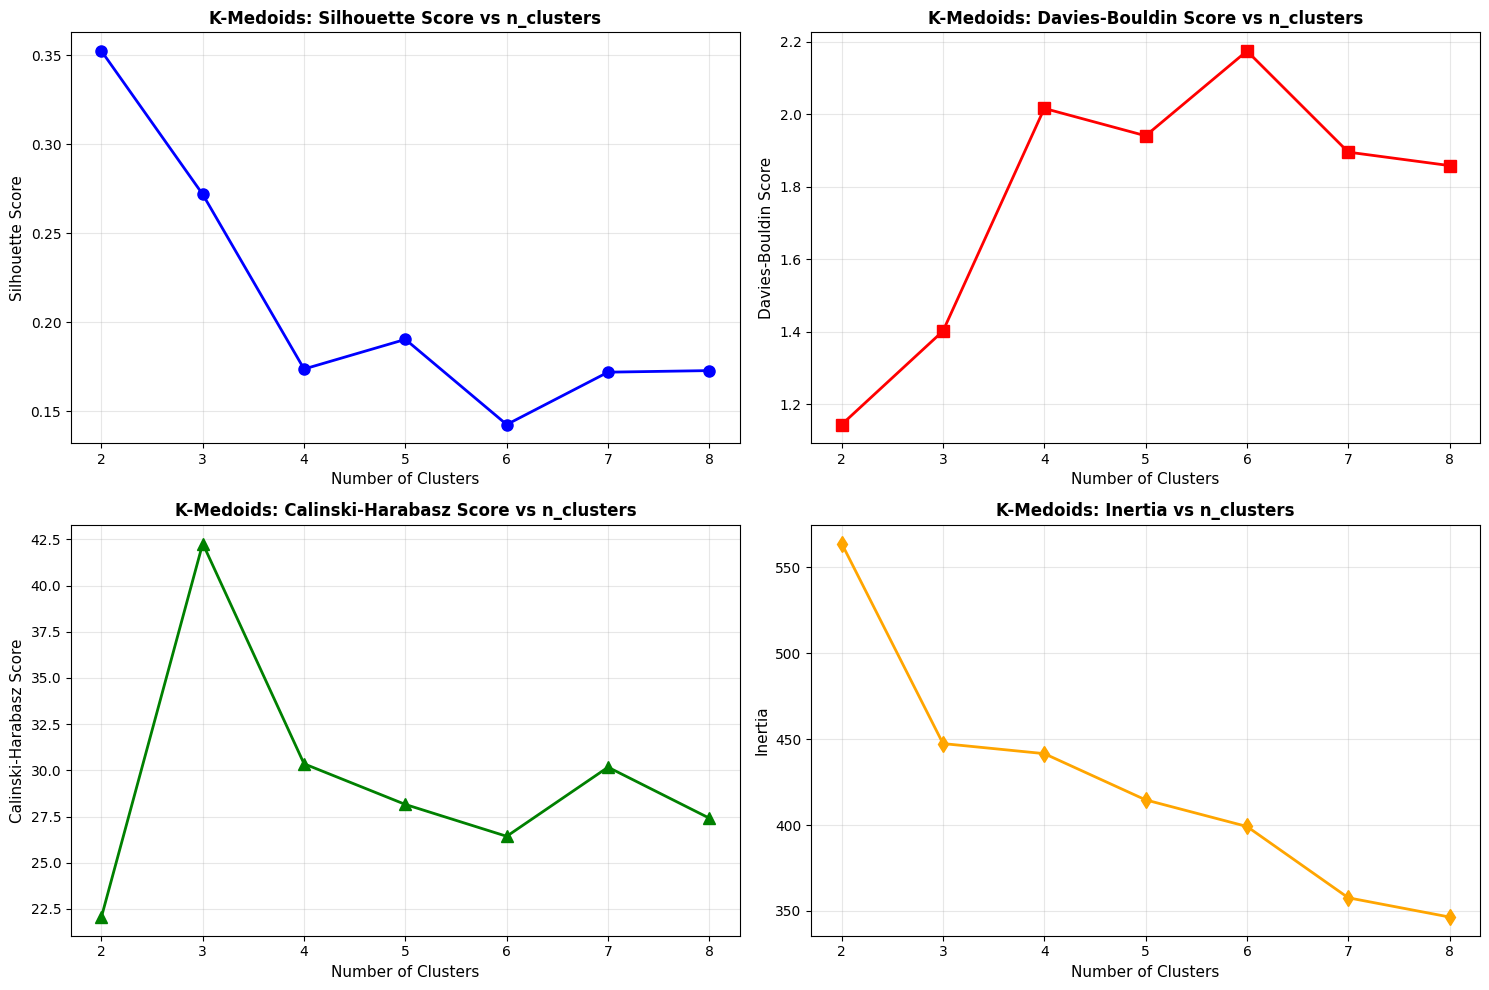

In [39]:
# Experiment 3: Different Number of Clusters for K-Medoids
print("\n" + "="*70)
print("EXPERIMENT 3: Impact of Number of Clusters (n_clusters)")
print("="*70 + "\n")

n_clusters_values_kmedoids = [2, 3, 4, 5, 6, 7, 8]

results_kmedoids_clusters = []

for n_clusters_val in n_clusters_values_kmedoids:
    print(f"Testing n_clusters: {n_clusters_val}")
    print("-" * 50)
    
    kmedoids = KMedoids(n_clusters=n_clusters_val, metric='euclidean', init='build', random_state=RANDOM_STATE)
    kmedoids.fit(X_clustering_scaled)
    
    sil_score = silhouette_score(X_clustering_scaled, kmedoids.labels_)
    db_score = davies_bouldin_score(X_clustering_scaled, kmedoids.labels_)
    ch_score = calinski_harabasz_score(X_clustering_scaled, kmedoids.labels_)
    
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Davies-Bouldin Score: {db_score:.4f}")
    print(f"Calinski-Harabasz Score: {ch_score:.2f}")
    print(f"Inertia: {kmedoids.inertia_:.2f}\n")
    
    results_kmedoids_clusters.append({
        'n_clusters': n_clusters_val,
        'Silhouette Score': sil_score,
        'Davies-Bouldin Score': db_score,
        'Calinski-Harabasz Score': ch_score,
        'Inertia': kmedoids.inertia_
    })

results_kmedoids_clusters_df = pd.DataFrame(results_kmedoids_clusters)
print("="*70)
print("SUMMARY - Number of Clusters Comparison:")
print("="*70)
print(results_kmedoids_clusters_df.to_string(index=False))

# Visualize K-Medoids n_clusters impact
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(results_kmedoids_clusters_df['n_clusters'], results_kmedoids_clusters_df['Silhouette Score'], 
                marker='o', linestyle='-', linewidth=2, markersize=8, color='blue')
axes[0, 0].set_xlabel('Number of Clusters', fontsize=11)
axes[0, 0].set_ylabel('Silhouette Score', fontsize=11)
axes[0, 0].set_title('K-Medoids: Silhouette Score vs n_clusters', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(results_kmedoids_clusters_df['n_clusters'], results_kmedoids_clusters_df['Davies-Bouldin Score'], 
                marker='s', linestyle='-', linewidth=2, markersize=8, color='red')
axes[0, 1].set_xlabel('Number of Clusters', fontsize=11)
axes[0, 1].set_ylabel('Davies-Bouldin Score', fontsize=11)
axes[0, 1].set_title('K-Medoids: Davies-Bouldin Score vs n_clusters', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(results_kmedoids_clusters_df['n_clusters'], results_kmedoids_clusters_df['Calinski-Harabasz Score'], 
                marker='^', linestyle='-', linewidth=2, markersize=8, color='green')
axes[1, 0].set_xlabel('Number of Clusters', fontsize=11)
axes[1, 0].set_ylabel('Calinski-Harabasz Score', fontsize=11)
axes[1, 0].set_title('K-Medoids: Calinski-Harabasz Score vs n_clusters', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(results_kmedoids_clusters_df['n_clusters'], results_kmedoids_clusters_df['Inertia'], 
                marker='d', linestyle='-', linewidth=2, markersize=8, color='orange')
axes[1, 1].set_xlabel('Number of Clusters', fontsize=11)
axes[1, 1].set_ylabel('Inertia', fontsize=11)
axes[1, 1].set_title('K-Medoids: Inertia vs n_clusters', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


FINAL K-MEDOIDS CLUSTERING WITH OPTIMAL PARAMETERS

Optimal K-Medoids Model:
  Number of Clusters: 3
  Distance Metric: euclidean
  Initialization: build

Performance Metrics:
  Silhouette Score: 0.2719
  Davies-Bouldin Score: 1.4021
  Calinski-Harabasz Score: 42.28
  Inertia: 447.40

Cluster Distribution:
  Cluster 0: 77 samples (46.1%)
  Cluster 1: 9 samples (5.4%)
  Cluster 2: 81 samples (48.5%)


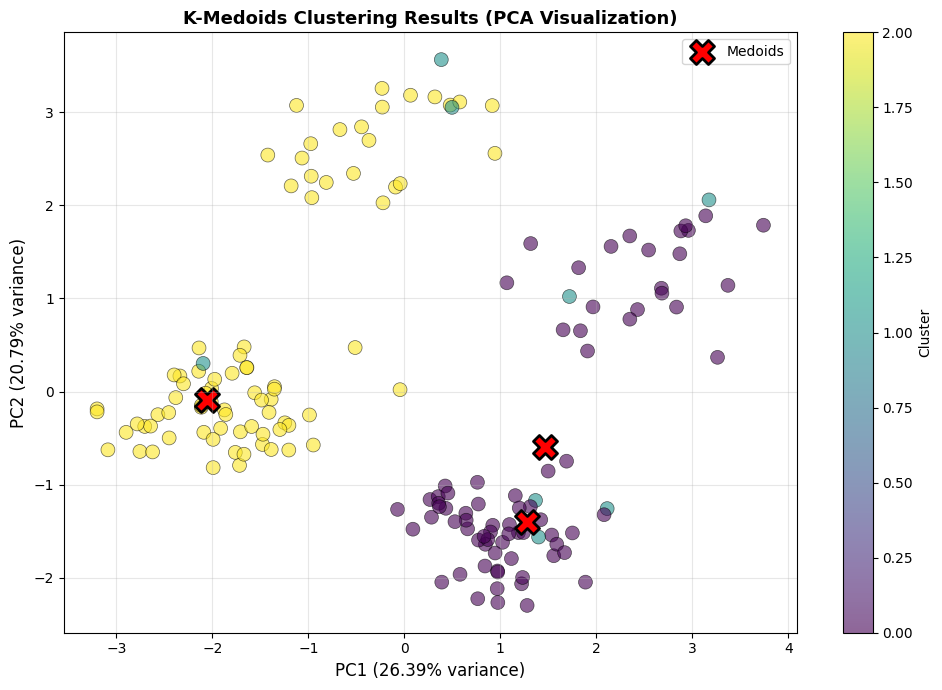


K-MEANS vs K-MEDOIDS COMPARISON

                 Metric   K-Means  K-Medoids
       Silhouette Score  0.263847   0.271918
   Davies-Bouldin Score  1.433423   1.402054
Calinski-Harabasz Score 48.712045  42.276258

Key Differences:
  K-Means uses cluster centroids (mean of points)
  K-Medoids uses actual data points as cluster representatives (more robust to outliers)

Based on metrics:
  K-Medoids performs better on this dataset


In [40]:
# Final K-Medoids Model with Optimal Parameters
print("\n" + "="*70)
print("FINAL K-MEDOIDS CLUSTERING WITH OPTIMAL PARAMETERS")
print("="*70 + "\n")

optimal_kmedoids = KMedoids(n_clusters=3, metric='euclidean', init='build', random_state=RANDOM_STATE)
optimal_kmedoids.fit(X_clustering_scaled)

print(f"Optimal K-Medoids Model:")
print(f"  Number of Clusters: 3")
print(f"  Distance Metric: euclidean")
print(f"  Initialization: build")
print(f"\nPerformance Metrics:")
print(f"  Silhouette Score: {silhouette_score(X_clustering_scaled, optimal_kmedoids.labels_):.4f}")
print(f"  Davies-Bouldin Score: {davies_bouldin_score(X_clustering_scaled, optimal_kmedoids.labels_):.4f}")
print(f"  Calinski-Harabasz Score: {calinski_harabasz_score(X_clustering_scaled, optimal_kmedoids.labels_):.2f}")
print(f"  Inertia: {optimal_kmedoids.inertia_:.2f}")

# Cluster distribution
unique, counts = np.unique(optimal_kmedoids.labels_, return_counts=True)
print(f"\nCluster Distribution:")
for cluster_id, count in zip(unique, counts):
    print(f"  Cluster {cluster_id}: {count} samples ({count/len(optimal_kmedoids.labels_)*100:.1f}%)")

# Visualize K-Medoids clusters using PCA
X_pca = pca.transform(X_clustering_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=optimal_kmedoids.labels_, 
                     cmap='viridis', s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
medoids_pca = pca.transform(X_clustering_scaled[optimal_kmedoids.medoid_indices_])
plt.scatter(medoids_pca[:, 0], medoids_pca[:, 1], c='red', marker='X', 
           s=300, edgecolors='black', linewidth=2, label='Medoids')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.title('K-Medoids Clustering Results (PCA Visualization)', fontsize=13, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Comparison: K-Means vs K-Medoids
print("\n" + "="*70)
print("K-MEANS vs K-MEDOIDS COMPARISON")
print("="*70 + "\n")

comparison_data = {
    'Metric': ['Silhouette Score', 'Davies-Bouldin Score', 'Calinski-Harabasz Score'],
    'K-Means': [
        silhouette_score(X_clustering_scaled, optimal_kmeans.labels_),
        davies_bouldin_score(X_clustering_scaled, optimal_kmeans.labels_),
        calinski_harabasz_score(X_clustering_scaled, optimal_kmeans.labels_)
    ],
    'K-Medoids': [
        silhouette_score(X_clustering_scaled, optimal_kmedoids.labels_),
        davies_bouldin_score(X_clustering_scaled, optimal_kmedoids.labels_),
        calinski_harabasz_score(X_clustering_scaled, optimal_kmedoids.labels_)
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\nKey Differences:")
print(f"  K-Means uses cluster centroids (mean of points)")
print(f"  K-Medoids uses actual data points as cluster representatives (more robust to outliers)")
print(f"\nBased on metrics:")
kmeans_score = sum([1 if comparison_df['K-Means'].iloc[0] > comparison_df['K-Medoids'].iloc[0] else 0,
                    1 if comparison_df['K-Means'].iloc[1] < comparison_df['K-Medoids'].iloc[1] else 0,
                    1 if comparison_df['K-Means'].iloc[2] > comparison_df['K-Medoids'].iloc[2] else 0])
if kmeans_score > 1.5:
    print("  K-Means performs better on this dataset")
else:
    print("  K-Medoids performs better on this dataset")

### 10.3 Hierarchical Clustering (Agglomerative)

**What we do here:**
- Perform Agglomerative Hierarchical Clustering
- Test all linkage methods: ward, complete, average, single
- Analyze how each linkage method affects clustering structure
- Draw dendrograms to visualize cluster formation
- Compare performance across different linkage methods


HIERARCHICAL CLUSTERING ANALYSIS

Testing Hierarchical Clustering with 167 samples
(Dendrogram will use 100 samples for clarity)


Testing Linkage Method: WARD
----------------------------------------------------------------------
Silhouette Score: 0.2640
Davies-Bouldin Score: 1.5483
Calinski-Harabasz Score: 42.63
Cluster Distribution:
  Cluster 0: 94 samples (56.3%)
  Cluster 1: 32 samples (19.2%)
  Cluster 2: 41 samples (24.6%)

Testing Linkage Method: COMPLETE
----------------------------------------------------------------------
Silhouette Score: 0.2719
Davies-Bouldin Score: 1.4021
Calinski-Harabasz Score: 42.28
Cluster Distribution:
  Cluster 0: 81 samples (48.5%)
  Cluster 1: 77 samples (46.1%)
  Cluster 2: 9 samples (5.4%)

Testing Linkage Method: AVERAGE
----------------------------------------------------------------------
Silhouette Score: 0.3078
Davies-Bouldin Score: 1.2760
Calinski-Harabasz Score: 31.89
Cluster Distribution:
  Cluster 0: 23 samples (13.8%)
  Cluster 1: 9 s

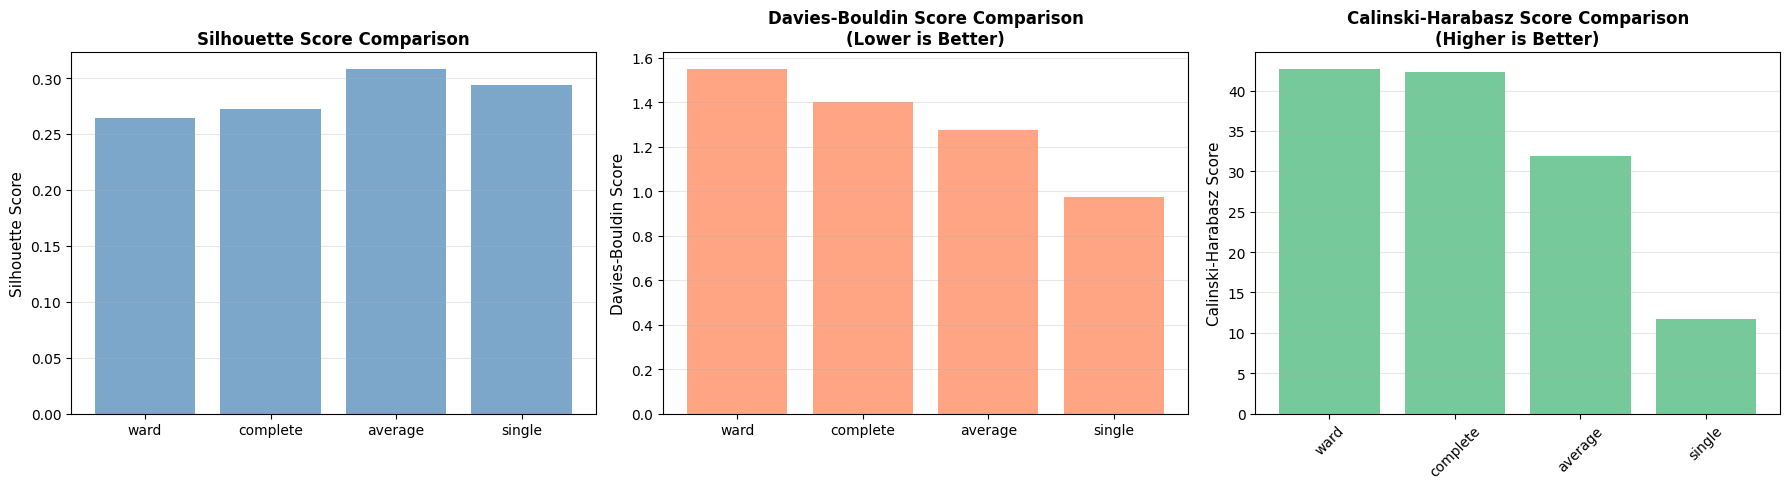

In [41]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

print("\n" + "="*70)
print("HIERARCHICAL CLUSTERING ANALYSIS")
print("="*70 + "\n")

# Linkage methods to test
linkage_methods = ['ward', 'complete', 'average', 'single']

# Store results for each linkage method
hierarchical_results = {}

# Use a subset of data for dendrogram visualization (for clarity)
sample_size = 100
np.random.seed(RANDOM_STATE)
sample_indices = np.random.choice(X_clustering_scaled.shape[0], sample_size, replace=False)
X_sample = X_clustering_scaled[sample_indices]

print(f"Testing Hierarchical Clustering with {len(X_clustering_scaled)} samples")
print(f"(Dendrogram will use {sample_size} samples for clarity)\n")

# Test each linkage method
for linkage_method in linkage_methods:
    print(f"\nTesting Linkage Method: {linkage_method.upper()}")
    print("-" * 70)
    
    # Perform hierarchical clustering on full dataset
    hierarchical = AgglomerativeClustering(n_clusters=3, linkage=linkage_method)
    labels = hierarchical.fit_predict(X_clustering_scaled)
    
    # Evaluate metrics
    sil_score = silhouette_score(X_clustering_scaled, labels)
    db_score = davies_bouldin_score(X_clustering_scaled, labels)
    ch_score = calinski_harabasz_score(X_clustering_scaled, labels)
    
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Davies-Bouldin Score: {db_score:.4f}")
    print(f"Calinski-Harabasz Score: {ch_score:.2f}")
    
    # Cluster distribution
    unique, counts = np.unique(labels, return_counts=True)
    print(f"Cluster Distribution:")
    for cluster_id, count in zip(unique, counts):
        print(f"  Cluster {cluster_id}: {count} samples ({count/len(labels)*100:.1f}%)")
    
    hierarchical_results[linkage_method] = {
        'labels': labels,
        'Silhouette Score': sil_score,
        'Davies-Bouldin Score': db_score,
        'Calinski-Harabasz Score': ch_score
    }

# Summary comparison
print("\n" + "="*70)
print("SUMMARY - HIERARCHICAL CLUSTERING LINKAGE METHODS COMPARISON")
print("="*70 + "\n")

summary_data = {
    'Linkage Method': list(hierarchical_results.keys()),
    'Silhouette Score': [hierarchical_results[m]['Silhouette Score'] for m in linkage_methods],
    'Davies-Bouldin Score': [hierarchical_results[m]['Davies-Bouldin Score'] for m in linkage_methods],
    'Calinski-Harabasz Score': [hierarchical_results[m]['Calinski-Harabasz Score'] for m in linkage_methods]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].bar(summary_df['Linkage Method'], summary_df['Silhouette Score'], color='steelblue', alpha=0.7)
axes[0].set_ylabel('Silhouette Score', fontsize=11)
axes[0].set_title('Silhouette Score Comparison', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(summary_df['Linkage Method'], summary_df['Davies-Bouldin Score'], color='coral', alpha=0.7)
axes[1].set_ylabel('Davies-Bouldin Score', fontsize=11)
axes[1].set_title('Davies-Bouldin Score Comparison\n(Lower is Better)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

axes[2].bar(summary_df['Linkage Method'], summary_df['Calinski-Harabasz Score'], color='mediumseagreen', alpha=0.7)
axes[2].set_ylabel('Calinski-Harabasz Score', fontsize=11)
axes[2].set_title('Calinski-Harabasz Score Comparison\n(Higher is Better)', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



DENDROGRAMS - VISUALIZING HIERARCHICAL STRUCTURE

Generating dendrogram for WARD linkage...
Generating dendrogram for COMPLETE linkage...
Generating dendrogram for AVERAGE linkage...
Generating dendrogram for SINGLE linkage...


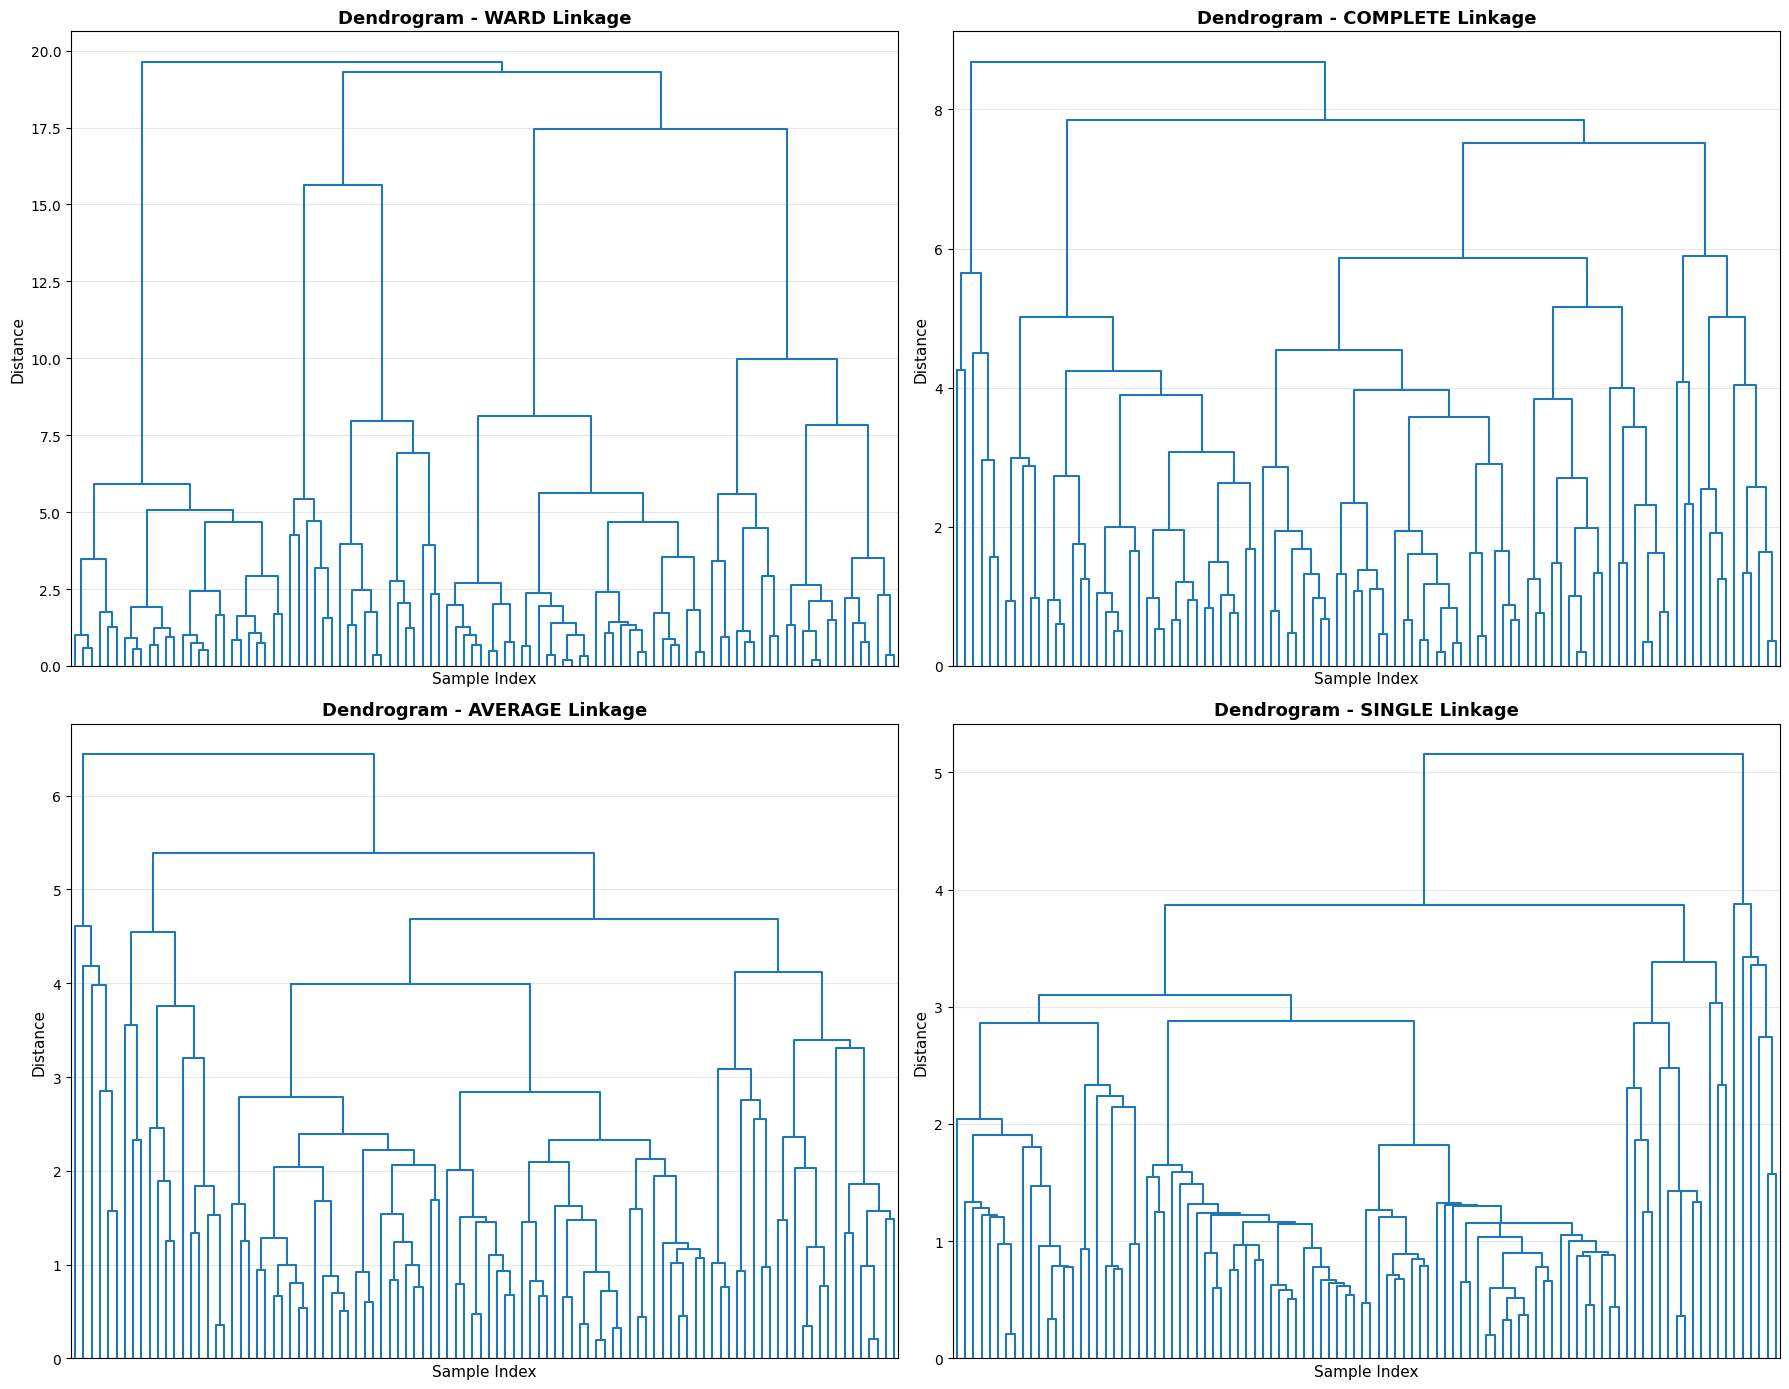

Dendrogram generation complete!


In [42]:
# Draw Dendrograms for Each Linkage Method
print("\n" + "="*70)
print("DENDROGRAMS - VISUALIZING HIERARCHICAL STRUCTURE")
print("="*70 + "\n")

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.ravel()

for idx, linkage_method in enumerate(linkage_methods):
    print(f"Generating dendrogram for {linkage_method.upper()} linkage...")
    
    # Compute linkage matrix on sample data
    Z = linkage(X_sample, method=linkage_method, metric='euclidean')
    
    # Plot dendrogram
    dendrogram(Z, ax=axes[idx], no_labels=True, color_threshold=0)
    axes[idx].set_title(f'Dendrogram - {linkage_method.upper()} Linkage', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Sample Index', fontsize=11)
    axes[idx].set_ylabel('Distance', fontsize=11)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Dendrogram generation complete!")



HIERARCHICAL CLUSTERING: IMPACT OF NUMBER OF CLUSTERS


Testing WARD Linkage with different cluster numbers:
----------------------------------------------------------------------
  n_clusters=2: Silhouette=0.2985, DB=1.7846, CH=35.29
  n_clusters=3: Silhouette=0.2640, DB=1.5483, CH=42.63
  n_clusters=4: Silhouette=0.2839, DB=1.3582, CH=49.70
  n_clusters=5: Silhouette=0.3272, DB=1.0978, CH=56.29
  n_clusters=6: Silhouette=0.3587, DB=1.0670, CH=56.87
  n_clusters=7: Silhouette=0.3689, DB=1.1390, CH=53.49
  n_clusters=8: Silhouette=0.3405, DB=1.1326, CH=51.72

Testing COMPLETE Linkage with different cluster numbers:
----------------------------------------------------------------------
  n_clusters=2: Silhouette=0.2328, DB=1.7954, CH=44.29
  n_clusters=3: Silhouette=0.2719, DB=1.4021, CH=42.28
  n_clusters=4: Silhouette=0.2849, DB=1.2488, CH=40.45
  n_clusters=5: Silhouette=0.3165, DB=1.2377, CH=41.27
  n_clusters=6: Silhouette=0.3259, DB=1.1159, CH=46.92
  n_clusters=7: Silhouette=0.3

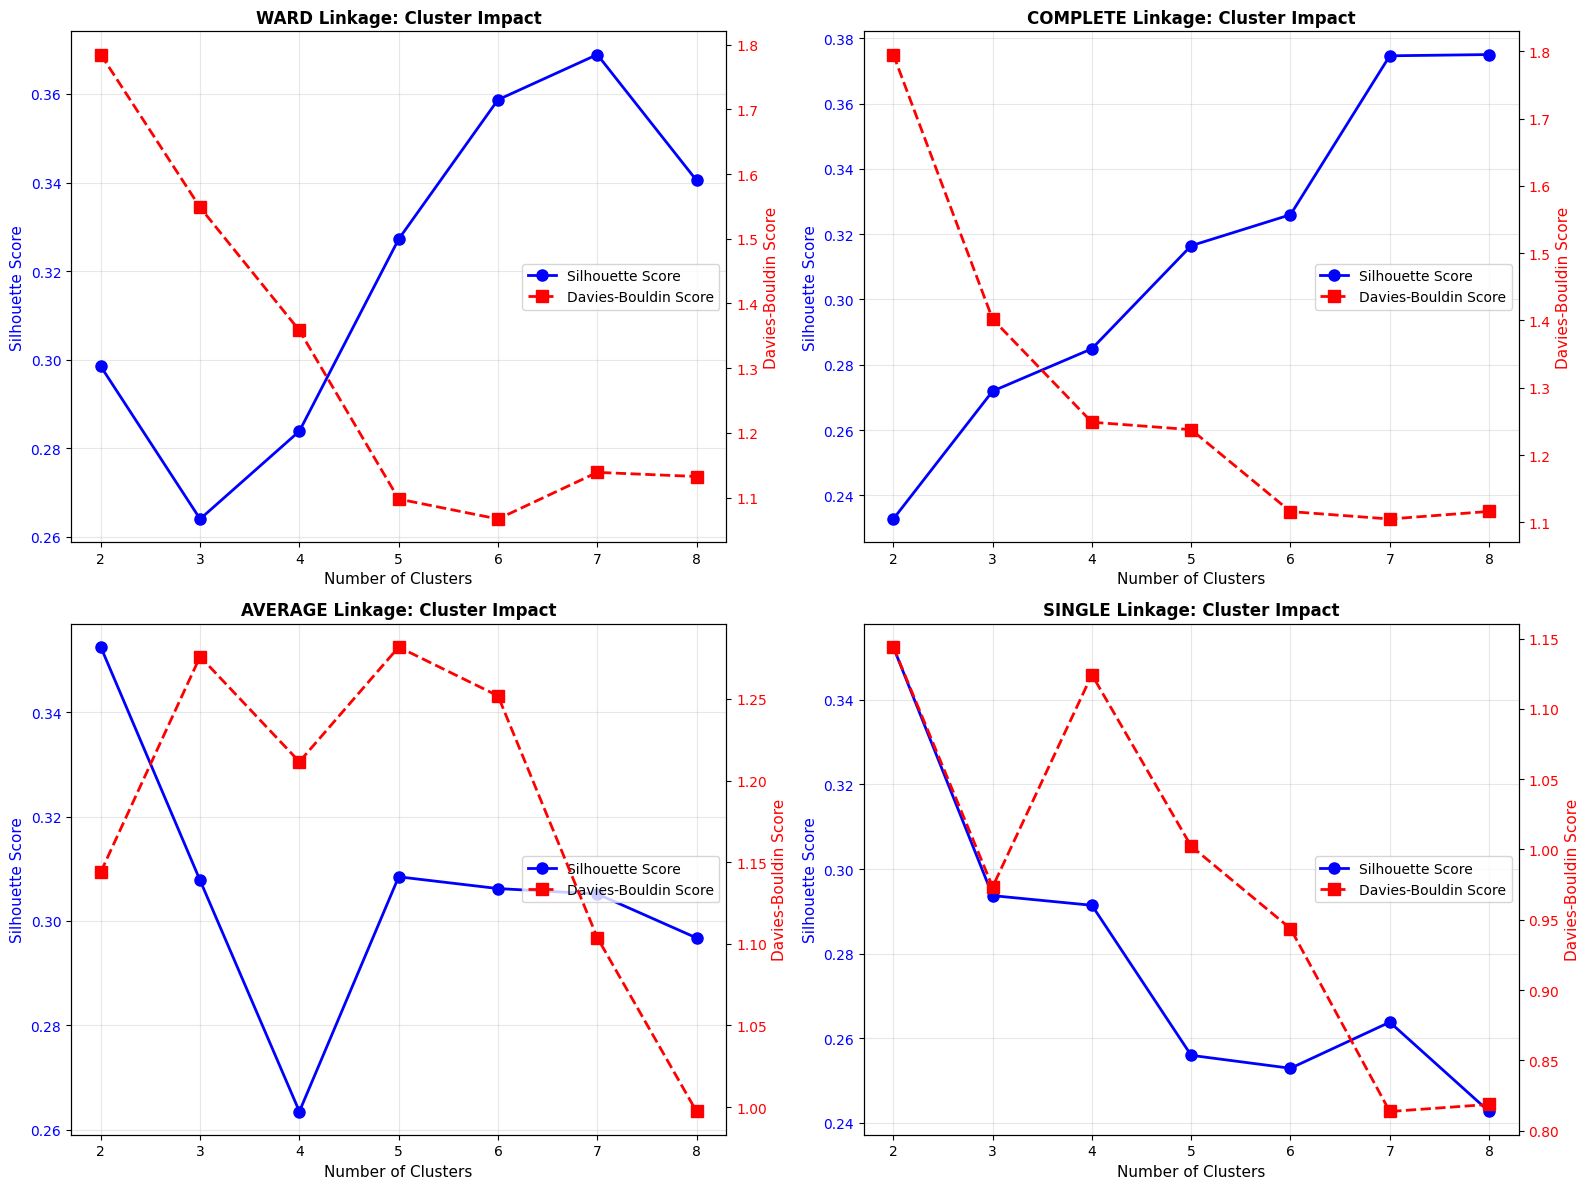


Analysis complete!


In [43]:
# Hierarchical Clustering with Different Numbers of Clusters
print("\n" + "="*70)
print("HIERARCHICAL CLUSTERING: IMPACT OF NUMBER OF CLUSTERS")
print("="*70 + "\n")

# Test different cluster numbers for each linkage method
n_clusters_range = [2, 3, 4, 5, 6, 7, 8]

hierarchical_nc_results = {}

for linkage_method in linkage_methods:
    print(f"\nTesting {linkage_method.upper()} Linkage with different cluster numbers:")
    print("-" * 70)
    
    results_by_nc = []
    
    for n_clusters_val in n_clusters_range:
        hierarchical = AgglomerativeClustering(n_clusters=n_clusters_val, linkage=linkage_method)
        labels = hierarchical.fit_predict(X_clustering_scaled)
        
        sil_score = silhouette_score(X_clustering_scaled, labels)
        db_score = davies_bouldin_score(X_clustering_scaled, labels)
        ch_score = calinski_harabasz_score(X_clustering_scaled, labels)
        
        results_by_nc.append({
            'n_clusters': n_clusters_val,
            'Silhouette Score': sil_score,
            'Davies-Bouldin Score': db_score,
            'Calinski-Harabasz Score': ch_score
        })
        
        print(f"  n_clusters={n_clusters_val}: Silhouette={sil_score:.4f}, DB={db_score:.4f}, CH={ch_score:.2f}")
    
    hierarchical_nc_results[linkage_method] = pd.DataFrame(results_by_nc)

# Visualize impact of cluster numbers for each linkage method
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, linkage_method in enumerate(linkage_methods):
    df = hierarchical_nc_results[linkage_method]
    
    ax1 = axes[idx]
    ax2 = ax1.twinx()
    
    line1 = ax1.plot(df['n_clusters'], df['Silhouette Score'], 
                     marker='o', linestyle='-', linewidth=2, markersize=8, 
                     color='blue', label='Silhouette Score')
    line2 = ax2.plot(df['n_clusters'], df['Davies-Bouldin Score'], 
                     marker='s', linestyle='--', linewidth=2, markersize=8, 
                     color='red', label='Davies-Bouldin Score')
    
    ax1.set_xlabel('Number of Clusters', fontsize=11)
    ax1.set_ylabel('Silhouette Score', fontsize=11, color='blue')
    ax2.set_ylabel('Davies-Bouldin Score', fontsize=11, color='red')
    ax1.set_title(f'{linkage_method.upper()} Linkage: Cluster Impact', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Combined legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='center right', fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Analysis complete!")



FINAL HIERARCHICAL CLUSTERING WITH OPTIMAL CONFIGURATION

Best Linkage Method: AVERAGE
(Based on Silhouette Score with 3 clusters)

Performance Metrics:
  Silhouette Score: 0.3078
  Davies-Bouldin Score: 1.2760
  Calinski-Harabasz Score: 31.89

Cluster Distribution:
  Cluster 0: 23 samples (13.8%)
  Cluster 1: 9 samples (5.4%)
  Cluster 2: 135 samples (80.8%)


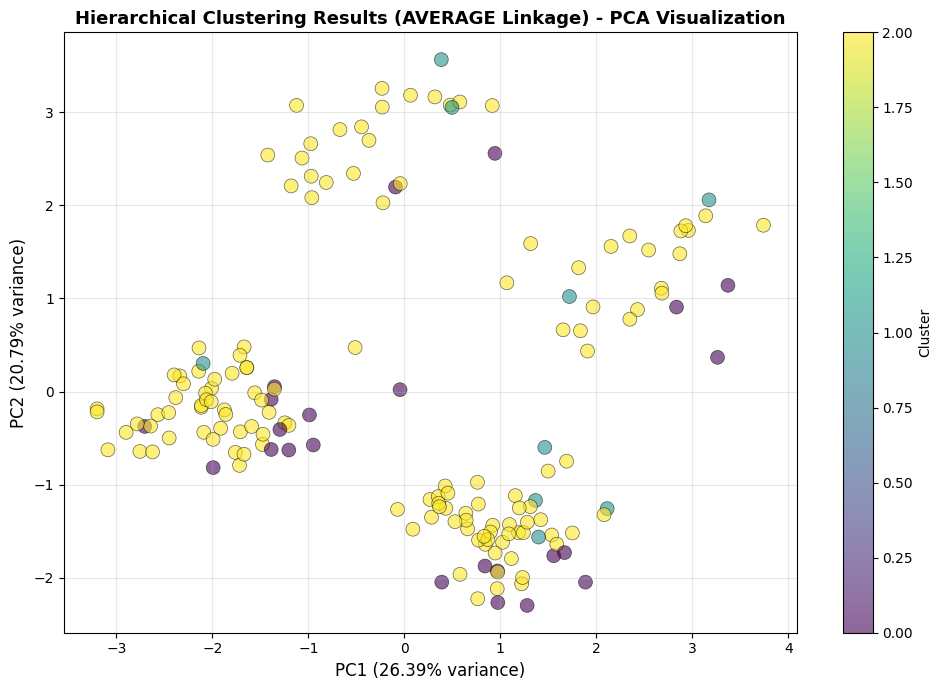


Generating detailed dendrogram for AVERAGE linkage...


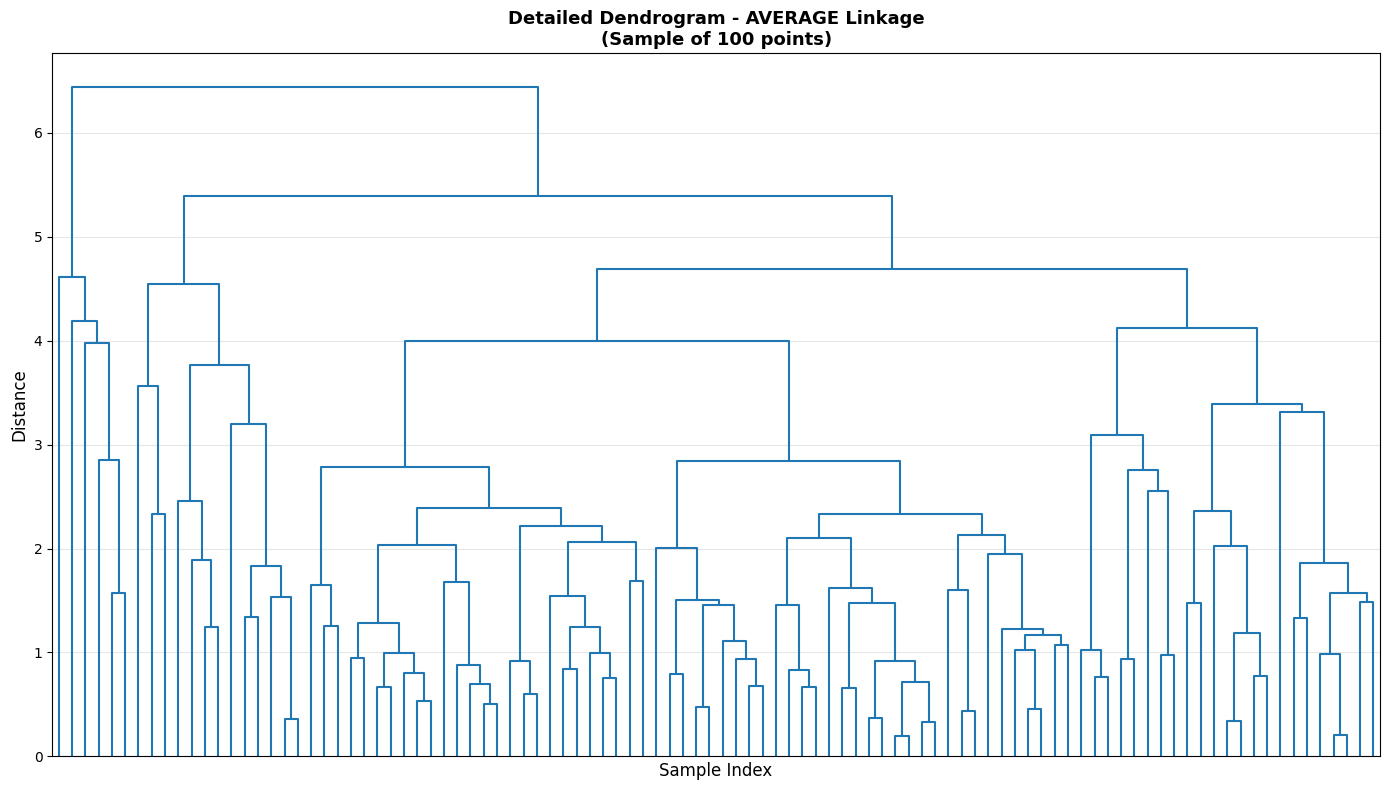


Dendrogram Interpretation for AVERAGE Linkage:
  - Height represents the distance between clusters
  - Horizontal lines represent merging of clusters
  - Longer vertical distances indicate more dissimilar clusters
  - Clusters form at different levels depending on the merge distance


In [44]:
# Final Hierarchical Model with Optimal Parameters and Visualization
print("\n" + "="*70)
print("FINAL HIERARCHICAL CLUSTERING WITH OPTIMAL CONFIGURATION")
print("="*70 + "\n")

# Select best linkage method based on silhouette score (at 3 clusters)
best_linkage = summary_df.loc[summary_df['Silhouette Score'].idxmax(), 'Linkage Method']

print(f"Best Linkage Method: {best_linkage.upper()}")
print(f"(Based on Silhouette Score with 3 clusters)\n")

optimal_hierarchical = AgglomerativeClustering(n_clusters=3, linkage=best_linkage)
optimal_hierarchical_labels = optimal_hierarchical.fit_predict(X_clustering_scaled)

print(f"Performance Metrics:")
print(f"  Silhouette Score: {silhouette_score(X_clustering_scaled, optimal_hierarchical_labels):.4f}")
print(f"  Davies-Bouldin Score: {davies_bouldin_score(X_clustering_scaled, optimal_hierarchical_labels):.4f}")
print(f"  Calinski-Harabasz Score: {calinski_harabasz_score(X_clustering_scaled, optimal_hierarchical_labels):.2f}")

# Cluster distribution
unique, counts = np.unique(optimal_hierarchical_labels, return_counts=True)
print(f"\nCluster Distribution:")
for cluster_id, count in zip(unique, counts):
    print(f"  Cluster {cluster_id}: {count} samples ({count/len(optimal_hierarchical_labels)*100:.1f}%)")

# Visualize hierarchical clustering results using PCA
X_pca = pca.transform(X_clustering_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=optimal_hierarchical_labels, 
                     cmap='viridis', s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.title(f'Hierarchical Clustering Results ({best_linkage.upper()} Linkage) - PCA Visualization', 
         fontsize=13, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create dendrogram for optimal model on sample
print(f"\nGenerating detailed dendrogram for {best_linkage.upper()} linkage...")
Z_optimal = linkage(X_sample, method=best_linkage, metric='euclidean')

plt.figure(figsize=(14, 8))
dendrogram(Z_optimal, no_labels=True, color_threshold=0)
plt.title(f'Detailed Dendrogram - {best_linkage.upper()} Linkage\n(Sample of {sample_size} points)', 
         fontsize=13, fontweight='bold')
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Interpretation of dendrogram
print(f"\nDendrogram Interpretation for {best_linkage.upper()} Linkage:")
print(f"  - Height represents the distance between clusters")
print(f"  - Horizontal lines represent merging of clusters")
print(f"  - Longer vertical distances indicate more dissimilar clusters")
print(f"  - Clusters form at different levels depending on the merge distance")



COMPREHENSIVE COMPARISON: K-MEANS vs K-MEDOIDS vs HIERARCHICAL

                Method  Silhouette Score  Davies-Bouldin Score  Calinski-Harabasz Score
               K-Means          0.263847              1.433423                48.712045
             K-Medoids          0.271918              1.402054                42.276258
Hierarchical (average)          0.307764              1.275974                31.894430


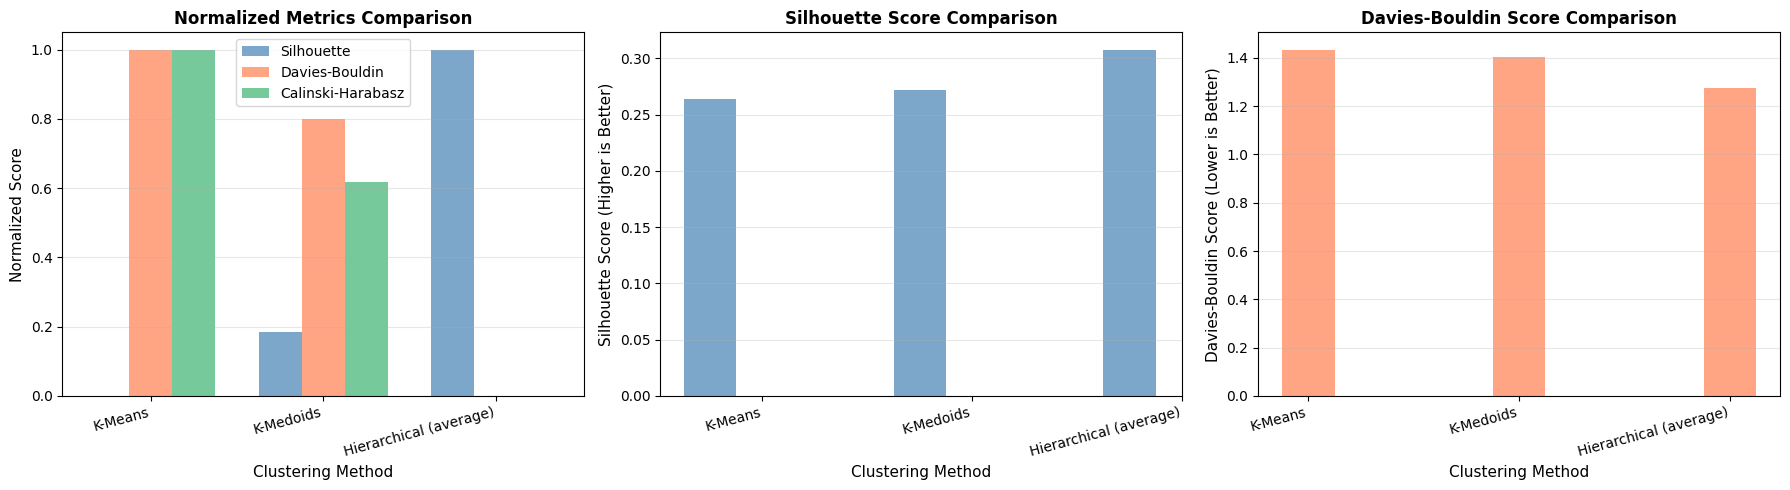


FINAL SUMMARY AND RECOMMENDATIONS

Model Characteristics:

1. K-MEANS:
   - Minimizes within-cluster variance (inertia)
   - Uses cluster centroids (mean points)
   - Fast and scalable
   - Sensitive to outliers
   - Requires specifying k in advance

2. K-MEDOIDS:
   - Uses actual data points as cluster representatives
   - More robust to outliers than K-Means
   - Slower computation than K-Means
   - Works with different distance metrics
   - Better interpretability (real medoid points)

3. HIERARCHICAL CLUSTERING:
   - Creates a dendrogram showing cluster hierarchy
   - No need to specify k in advance (can cut at any level)
   - Different linkage methods capture different structures:
     • Ward: Minimizes within-cluster variance (similar to K-Means)
     • Complete: Minimizes maximum distance between points
     • Average: Uses average distance between points
     • Single: Uses minimum distance (tends to chain)
   - More computationally expensive
   - Better for understanding hier

In [46]:
# Comprehensive Clustering Methods Comparison
print("\n" + "="*70)
print("COMPREHENSIVE COMPARISON: K-MEANS vs K-MEDOIDS vs HIERARCHICAL")
print("="*70 + "\n")

# Gather best results from each method
comparison_all = {
    'Method': ['K-Means', 'K-Medoids', f'Hierarchical ({best_linkage})'],
    'Silhouette Score': [
        silhouette_score(X_clustering_scaled, optimal_kmeans.labels_),
        silhouette_score(X_clustering_scaled, optimal_kmedoids.labels_),
        silhouette_score(X_clustering_scaled, optimal_hierarchical_labels)
    ],
    'Davies-Bouldin Score': [
        davies_bouldin_score(X_clustering_scaled, optimal_kmeans.labels_),
        davies_bouldin_score(X_clustering_scaled, optimal_kmedoids.labels_),
        davies_bouldin_score(X_clustering_scaled, optimal_hierarchical_labels)
    ],
    'Calinski-Harabasz Score': [
        calinski_harabasz_score(X_clustering_scaled, optimal_kmeans.labels_),
        calinski_harabasz_score(X_clustering_scaled, optimal_kmedoids.labels_),
        calinski_harabasz_score(X_clustering_scaled, optimal_hierarchical_labels)
    ]
}

comparison_all_df = pd.DataFrame(comparison_all)
print(comparison_all_df.to_string(index=False))

# Visualize comprehensive comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Normalize scores for comparison visualization
from sklearn.preprocessing import MinMaxScaler
scaler_viz = MinMaxScaler()
comparison_all_normalized = comparison_all_df.copy()
comparison_all_normalized.iloc[:, 1:] = scaler_viz.fit_transform(comparison_all_df.iloc[:, 1:])

x_pos = np.arange(len(comparison_all_normalized['Method']))
width = 0.25

axes[0].bar(x_pos - width, comparison_all_normalized['Silhouette Score'], width, 
           label='Silhouette', color='steelblue', alpha=0.7)
axes[0].bar(x_pos, comparison_all_normalized['Davies-Bouldin Score'], width, 
           label='Davies-Bouldin', color='coral', alpha=0.7)
axes[0].bar(x_pos + width, comparison_all_normalized['Calinski-Harabasz Score'], width, 
           label='Calinski-Harabasz', color='mediumseagreen', alpha=0.7)
axes[0].set_xlabel('Clustering Method', fontsize=11)
axes[0].set_ylabel('Normalized Score', fontsize=11)
axes[0].set_title('Normalized Metrics Comparison', fontsize=12, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison_all_normalized['Method'], rotation=15, ha='right')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# Actual metrics
axes[1].bar(x_pos - width, comparison_all_df['Silhouette Score'], width, 
           label='Silhouette', color='steelblue', alpha=0.7)
axes[1].set_xlabel('Clustering Method', fontsize=11)
axes[1].set_ylabel('Silhouette Score (Higher is Better)', fontsize=11)
axes[1].set_title('Silhouette Score Comparison', fontsize=12, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(comparison_all_df['Method'], rotation=15, ha='right')
axes[1].grid(True, alpha=0.3, axis='y')

axes[2].bar(x_pos, comparison_all_df['Davies-Bouldin Score'], width, 
           label='Davies-Bouldin', color='coral', alpha=0.7)
axes[2].set_xlabel('Clustering Method', fontsize=11)
axes[2].set_ylabel('Davies-Bouldin Score (Lower is Better)', fontsize=11)
axes[2].set_title('Davies-Bouldin Score Comparison', fontsize=12, fontweight='bold')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(comparison_all_df['Method'], rotation=15, ha='right')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Final Summary
print("\n" + "="*70)
print("FINAL SUMMARY AND RECOMMENDATIONS")
print("="*70 + "\n")

print("Model Characteristics:")
print("\n1. K-MEANS:")
print("   - Minimizes within-cluster variance (inertia)")
print("   - Uses cluster centroids (mean points)")
print("   - Fast and scalable")
print("   - Sensitive to outliers")
print("   - Requires specifying k in advance")

print("\n2. K-MEDOIDS:")
print("   - Uses actual data points as cluster representatives")
print("   - More robust to outliers than K-Means")
print("   - Slower computation than K-Means")
print("   - Works with different distance metrics")
print("   - Better interpretability (real medoid points)")

print("\n3. HIERARCHICAL CLUSTERING:")
print("   - Creates a dendrogram showing cluster hierarchy")
print("   - No need to specify k in advance (can cut at any level)")
print("   - Different linkage methods capture different structures:")
print("     • Ward: Minimizes within-cluster variance (similar to K-Means)")
print("     • Complete: Minimizes maximum distance between points")
print("     • Average: Uses average distance between points")
print("     • Single: Uses minimum distance (tends to chain)")
print("   - More computationally expensive")
print("   - Better for understanding hierarchical relationships")

# Determine best method
best_methods = []
if comparison_all_df['Silhouette Score'].max() == comparison_all_df['Silhouette Score'].iloc[0]:
    best_methods.append('K-Means')
elif comparison_all_df['Silhouette Score'].max() == comparison_all_df['Silhouette Score'].iloc[1]:
    best_methods.append('K-Medoids')
else:
    best_methods.append('Hierarchical')

print(f"\n{'='*70}")
print(f"RECOMMENDED METHOD for this dataset: {best_methods[0].upper()}")
print(f"Based on highest Silhouette Score of {comparison_all_df['Silhouette Score'].max():.4f}")
print(f"{'='*70}")